In [1]:
# Dependencies
import gempy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gempy.assets import topology as tp

import warnings

warnings.filterwarnings("ignore")

# Creating model object and indicating path
data_path = "../../../../input/BES/interpreted_seismics_2/processed/"

No module named 'osgeo'


In [2]:
surf_points = pd.read_csv(data_path + "sp_500m_not_scaled_500m_ajustado.csv") # Surface points
xmin, xmax, ymin, ymax = surf_points["X"].min(), surf_points["X"].max(), surf_points["Y"].min(), surf_points["Y"].max() # Limites do modelo
xlen, ylen = xmax - xmin, ymax - ymin # Tamanho do modelo
zmin, zmax = surf_points["Z"].min() -1000, 0 # Profundidade do modelo
res = [80, 50, 50] # Resolução do modelo

In [3]:
geo_model = gp.create_model("v1_500m_not_scaled")

# Loading model, the extension, the resolution and importing the data
gp.init_data(
    geo_model,
    extent=[xmin, xmax, ymin, ymax, zmin, zmax],
    resolution=res,
    #surface_points_df=surf_points,
    path_i=surf_points,
    #path_o=data_path + "op_top_mid_base_500m_not_scaled_500m_ajustado.csv",
)

Active grids: ['regular']


v1_500m_not_scaled  2024-03-15 15:43

In [6]:
print(gp.get_data(geo_model, 'series'), "\n", gp.get_data(geo_model, 'surfaces'))

          order_series BottomRelation  isActive  isFault  isFinite
top                  1        Erosion     False    False     False
mid                  2        Erosion     False    False     False
base                 3        Erosion     False    False     False
Basement             4        Erosion     False    False     False 
     surface    series  order_surfaces    color  id
0       top       top               1  #015482   1
1       mid       mid               1  #9f0052   2
2      base      base               1  #ffbe00   3
3  basement  Basement               1  #728f02   4


In [5]:
# Assigning series to surfaces
series = surf_points.formation.unique()
#geo_model.add_series(series)

# Assign each surface to a series
series_dict = {formation: formation for formation in series}
gp.map_stack_to_surfaces(geo_model, series_dict)

# Set bottom relation
geo_model.set_bottom_relation(series,"Erosion")

,order_series,BottomRelation,isActive,isFault,isFinite
top,1,Erosion,False,False,False
mid,2,Erosion,False,False,False
base,3,Erosion,False,False,False
Basement,4,Erosion,False,False,False


In [7]:
%%time
# Calculate orientation points
neighbours = gp.select_nearest_surfaces_points(geo_model, geo_model.surface_points.df, 2)
opoints = gp.set_orientation_from_neighbours_all(geo_model, neighbours)

CPU times: total: 2min 24s
Wall time: 2min 24s


In [8]:
geo_model.get_data()

X            Y        Z    smooth surface   
surface_points 0     431215.754  7785829.449 -2905.49  0.000002     top  \
               1     431515.754  7785829.449 -2925.77  0.000002     top   
               2     432015.754  7785829.449 -2965.06  0.000002     top   
               3     432515.754  7785829.449 -3004.24  0.000002     top   
               4     433015.754  7785829.449 -3043.23  0.000002     top   
...                         ...          ...      ...       ...     ...   
orientations   1735  472015.754  7795029.449 -6983.97  0.010000    base   
               1736  472515.754  7795029.449 -7006.51  0.010000    base   
               1737  473015.754  7795029.449 -7028.57  0.010000    base   
               1738  473515.754  7795029.449 -7050.33  0.010000    base   
               1739  474015.754  7795029.449 -7071.88  0.010000    base   

                          G_x       G_y       G_z  
surface_points 0          NaN       NaN       NaN  
               1          NaN       NaN       NaN  
               2          NaN       NaN       NaN  
               3          NaN       NaN       NaN  
               4          NaN       NaN       NaN  
...                       ...       ...       ...  
orientations   1735  0.045034  0.002777  0.998982  
               1736  0.044077  0.001219  0.999027  
               1737  0.043479 -0.000460  0.999054  
               1738  0.043060 -0.002098  0.999070  
               1739  0.043060 -0.003597  0.999066  

[10440 rows x 8 columns]

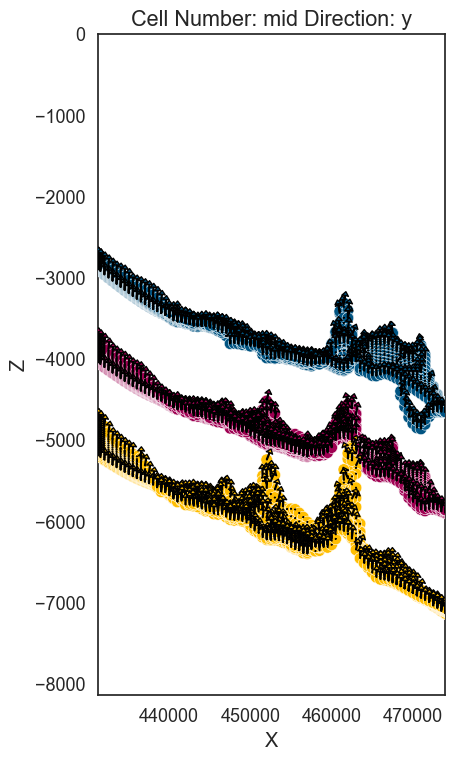

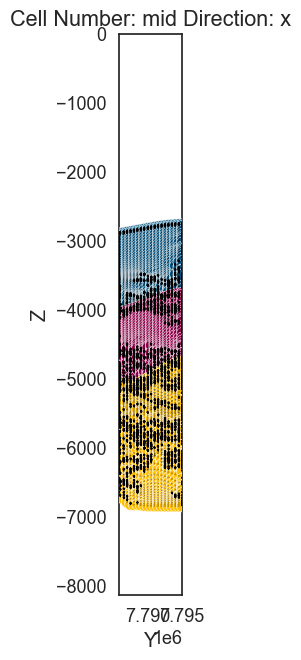

In [9]:
# Seção transversal do modelo
gp.plot_2d(
    geo_model, direction="y", show_data=True, show_lith=True, ve=10, legend=False
)
gp.plot_2d(
    geo_model, direction="x", show_data=True, show_lith=True, ve=10, legend=False
)
# gp.plot_2d(geo_model, direction="z", show_data=True, show_lith=True, ve=1, legend=False)

# Ver os dados em 3D
gpv = gp.plot_3d(
    geo_model,
    plotter_type="background",
    show_data=True,
    ve=5,
)

In [10]:
%%time
# Interpolating and computing the model
gp.set_interpolator(
    geo_model,
    output=["geology"],
    theano_optimizer="fast_run",  # fast_compile, fast_run
    dtype="float64",  # for model stability
)

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                           values
range               44528.267736
$C_o$            47208729.227514
drift equations     [3, 3, 3, 3]
CPU times: total: 17.6 s
Wall time: 18.6 s


In [12]:
geo_model.update_to_interpolator()

True

In [13]:
# Compute model
sol = gp.compute_model(
    geo_model, 
    #to_subsurface=True,
    )

ValueError: Input dimension mismatch. One other input has shape[1] = 718, but input[1].shape[1] = 172.
Apply node that caused the error: Elemwise{mul,no_inplace}(Subtensor{int64:int64:int8}.0, Subtensor{::, int64:int64:}.0)
Toposort index: 98
Inputs types: [TensorType(float64, (?, ?)), TensorType(float64, (?, ?))]
Inputs shapes: [(0, 718), (0, 172)]
Inputs strides: [(8, 55696), (1655648, 8)]
Inputs values: [array([], shape=(0, 718), dtype=float64), array([], shape=(0, 172), dtype=float64)]
Inputs type_num: [12, 12]
Outputs clients: [[Sum{axis=[0], acc_dtype=float64}(Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 463, in compute_series
    series, self.updates1 = aesara.scan(
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\aesara\scan\basic.py", line 856, in scan
    raw_inner_outputs = fn(*args)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 2137, in compute_a_series
    self.compute_scalar_field(weights, grid,
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 432, in compute_scalar_field
    return self.scalar_field_at_all(weights, grid_val, fault_matrix)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 1721, in scalar_field_at_all
    Z_x_loop, updates3 = aesara.scan(
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\aesara\scan\basic.py", line 856, in scan
    raw_inner_outputs = fn(*args)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 1680, in scalar_field_loop
    f_1 = self.contribution_faults(tiled_weights[:, :], a, b, fault_matrix)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 1645, in contribution_faults
    weights[length_of_CG + length_of_CGI + length_of_U_I:,

Debug print of the apply node: 
Elemwise{mul,no_inplace} [id A] <TensorType(float64, (?, ?))>
 |Subtensor{int64:int64:int8} [id B] <TensorType(float64, (?, ?))>
 | |InplaceDimShuffle{1,0} [id C] <TensorType(float64, (?, ?))>
 | | |Reshape{2} [id D] <TensorType(float64, (?, ?))>
 | |   |Alloc [id E] <TensorType(float64, (?, 1, 1, ?))>
 | |   | |*7-<TensorType(float64, (?,))> [id F] <TensorType(float64, (?,))>
 | |   | |Elemwise{sub,no_inplace} [id G] <TensorType(int64, ())>
 | |   | | |*1-<TensorType(int64, ())> [id H] <TensorType(int64, ())>
 | |   | | |*0-<TensorType(int64, ())> [id I] <TensorType(int64, ())>
 | |   | |TensorConstant{1} [id J] <TensorType(int8, ())>
 | |   | |TensorConstant{1} [id J] <TensorType(int8, ())>
 | |   | |Shape_i{0} [id K] <TensorType(int64, ())>
 | |   |   |*7-<TensorType(float64, (?,))> [id F] <TensorType(float64, (?,))>
 | |   |MakeVector{dtype='int64'} [id L] <TensorType(int64, (2,))>
 | |     |Elemwise{sub,no_inplace} [id G] <TensorType(int64, ())>
 | |     |Shape_i{0} [id K] <TensorType(int64, ())>
 | |ScalarFromTensor [id M] <int64>
 | | |Elemwise{switch,no_inplace} [id N] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id O] <TensorType(bool, ())>
 | |   | |Elemwise{sub,no_inplace} [id P] <TensorType(int64, ())>
 | |   | | |Shape_i{0} [id K] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id Q] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id R] <TensorType(bool, ())>
 | |   | |   | |Elemwise{add,no_inplace} [id S] <TensorType(int64, ())>
 | |   | |   | | |Elemwise{switch,no_inplace} [id T] <TensorType(int64, ())>
 | |   | |   | | | |Elemwise{eq,no_inplace} [id U] <TensorType(bool, ())>
 | |   | |   | | | | |Elemwise{mul,no_inplace} [id V] <TensorType(int64, ())>
 | |   | |   | | | | | |TensorConstant{3} [id W] <TensorType(int64, ())>
 | |   | |   | | | | | |Elemwise{sub,no_inplace} [id X] <TensorType(int64, ())>
 | |   | |   | | | | |   |Elemwise{switch,no_inplace} [id Y] <TensorType(int64, ())>
 | |   | |   | | | | |   | |Elemwise{lt,no_inplace} [id Z] <TensorType(bool, ())>
 | |   | |   | | | | |   | | |Elemwise{switch,no_inplace} [id BA] <TensorType(int64, ())>
 | |   | |   | | | | |   | | | |Elemwise{ge,no_inplace} [id BB] <TensorType(bool, ())>
 | |   | |   | | | | |   | | | | |Elemwise{switch,no_inplace} [id BC] <TensorType(int64, ())>
 | |   | |   | | | | |   | | | | | |Elemwise{lt,no_inplace} [id BD] <TensorType(bool, ())>
 | |   | |   | | | | |   | | | | | | |Elemwise{switch,no_inplace} [id BE] <TensorType(int64, ())>
 | |   | |   | | | | |   | | | | | | | |Elemwise{lt,no_inplace} [id BF] <TensorType(bool, ())>
 | |   | |   | | | | |   | | | | | | | | |*11-<TensorType(int32, ())> [id BG] <TensorType(int32, ())>
 | |   | |   | | | | |   | | | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |   | | | | | | | |TensorFromScalar [id BI] <TensorType(int64, ())>
 | |   | |   | | | | |   | | | | | | | | |add [id BJ] <int64>
 | |   | |   | | | | |   | | | | | | | |   |ScalarFromTensor [id BK] <int32>
 | |   | |   | | | | |   | | | | | | | |   | |*11-<TensorType(int32, ())> [id BG] <TensorType(int32, ())>
 | |   | |   | | | | |   | | | | | | | |   |ScalarFromTensor [id BL] <int64>
 | |   | |   | | | | |   | | | | | | | |     |Shape_i{0} [id BM] <TensorType(int64, ())>
 | |   | |   | | | | |   | | | | | | | |       |*9-<TensorType(float64, (?, ?))> [id BN] <TensorType(float64, (?, ?))>
 | |   | |   | | | | |   | | | | | | | |*11-<TensorType(int32, ())> [id BG] <TensorType(int32, ())>
 | |   | |   | | | | |   | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |   | | | | | |TensorConstant{-1} [id BO] <TensorType(int8, ())>
 | |   | |   | | | | |   | | | | | |Elemwise{switch,no_inplace} [id BE] <TensorType(int64, ())>
 | |   | |   | | | | |   | | | | |Shape_i{0} [id BM] <TensorType(int64, ())>
 | |   | |   | | | | |   | | | |Shape_i{0} [id BM] <TensorType(int64, ())>
 | |   | |   | | | | |   | | | |Elemwise{switch,no_inplace} [id BC] <TensorType(int64, ())>
 | |   | |   | | | | |   | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |   | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |   | |Elemwise{switch,no_inplace} [id BA] <TensorType(int64, ())>
 | |   | |   | | | | |   |Elemwise{switch,no_inplace} [id BP] <TensorType(int64, ())>
 | |   | |   | | | | |     |Elemwise{lt,no_inplace} [id BQ] <TensorType(bool, ())>
 | |   | |   | | | | |     | |Elemwise{switch,no_inplace} [id BR] <TensorType(int64, ())>
 | |   | |   | | | | |     | | |Elemwise{lt,no_inplace} [id BS] <TensorType(bool, ())>
 | |   | |   | | | | |     | | | |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | |   | |   | | | | |     | | | | |Elemwise{ge,no_inplace} [id BU] <TensorType(bool, ())>
 | |   | |   | | | | |     | | | | | |Elemwise{switch,no_inplace} [id BV] <TensorType(int64, ())>
 | |   | |   | | | | |     | | | | | | |Elemwise{lt,no_inplace} [id BW] <TensorType(bool, ())>
 | |   | |   | | | | |     | | | | | | | |Elemwise{switch,no_inplace} [id BX] <TensorType(int64, ())>
 | |   | |   | | | | |     | | | | | | | | |Elemwise{lt,no_inplace} [id BY] <TensorType(bool, ())>
 | |   | |   | | | | |     | | | | | | | | | |*10-<TensorType(int32, ())> [id BZ] <TensorType(int32, ())>
 | |   | |   | | | | |     | | | | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |     | | | | | | | | |TensorFromScalar [id CA] <TensorType(int64, ())>
 | |   | |   | | | | |     | | | | | | | | | |add [id CB] <int64>
 | |   | |   | | | | |     | | | | | | | | |   |ScalarFromTensor [id CC] <int32>
 | |   | |   | | | | |     | | | | | | | | |   | |*10-<TensorType(int32, ())> [id BZ] <TensorType(int32, ())>
 | |   | |   | | | | |     | | | | | | | | |   |ScalarFromTensor [id BL] <int64>
 | |   | |   | | | | |     | | | | | | | | |*10-<TensorType(int32, ())> [id BZ] <TensorType(int32, ())>
 | |   | |   | | | | |     | | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |     | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |     | | | | | | |Elemwise{switch,no_inplace} [id BX] <TensorType(int64, ())>
 | |   | |   | | | | |     | | | | | |Shape_i{0} [id BM] <TensorType(int64, ())>
 | |   | |   | | | | |     | | | | |Shape_i{0} [id BM] <TensorType(int64, ())>
 | |   | |   | | | | |     | | | | |Elemwise{switch,no_inplace} [id BV] <TensorType(int64, ())>
 | |   | |   | | | | |     | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |     | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |     | | |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | |   | |   | | | | |     | |Elemwise{switch,no_inplace} [id Y] <TensorType(int64, ())>
 | |   | |   | | | | |     |Elemwise{switch,no_inplace} [id BR] <TensorType(int64, ())>
 | |   | |   | | | | |     |Elemwise{switch,no_inplace} [id Y] <TensorType(int64, ())>
 | |   | |   | | | | |TensorConstant{-1} [id BO] <TensorType(int8, ())>
 | |   | |   | | | |Elemwise{floor_divide,no_inplace} [id CD] <TensorType(int64, ())>
 | |   | |   | | | | |Elemwise{mul,no_inplace} [id CE] <TensorType(int64, ())>
 | |   | |   | | | | | |TensorConstant{3} [id W] <TensorType(int64, ())>
 | |   | |   | | | | | |Elemwise{sub,no_inplace} [id X] <TensorType(int64, ())>
 | |   | |   | | | | | |Shape_i{1} [id CF] <TensorType(int64, ())>
 | |   | |   | | | | |   |*9-<TensorType(float64, (?, ?))> [id BN] <TensorType(float64, (?, ?))>
 | |   | |   | | | | |Elemwise{scalar_maximum,no_inplace} [id CG] <TensorType(int64, ())>
 | |   | |   | | | |   |Elemwise{mul,no_inplace} [id CH] <TensorType(int64, ())>
 | |   | |   | | | |   | |TensorConstant{-3} [id CI] <TensorType(int64, ())>
 | |   | |   | | | |   | |Elemwise{sub,no_inplace} [id X] <TensorType(int64, ())>
 | |   | |   | | | |   | |Shape_i{1} [id CF] <TensorType(int64, ())>
 | |   | |   | | | |   |TensorConstant{1} [id CJ] <TensorType(int64, ())>
 | |   | |   | | | |Elemwise{mul,no_inplace} [id V] <TensorType(int64, ())>
 | |   | |   | | |Elemwise{sub,no_inplace} [id CK] <TensorType(int64, ())>
 | |   | |   | | | |Elemwise{switch,no_inplace} [id CL] <TensorType(int64, ())>
 | |   | |   | | | | |Elemwise{lt,no_inplace} [id CM] <TensorType(bool, ())>
 | |   | |   | | | | | |Elemwise{switch,no_inplace} [id CN] <TensorType(int64, ())>
 | |   | |   | | | | | | |Elemwise{ge,no_inplace} [id CO] <TensorType(bool, ())>
 | |   | |   | | | | | | | |Elemwise{switch,no_inplace} [id CP] <TensorType(int64, ())>
 | |   | |   | | | | | | | | |Elemwise{lt,no_inplace} [id CQ] <TensorType(bool, ())>
 | |   | |   | | | | | | | | | |Elemwise{switch,no_inplace} [id CR] <TensorType(int64, ())>
 | |   | |   | | | | | | | | | | |Elemwise{lt,no_inplace} [id CS] <TensorType(bool, ())>
 | |   | |   | | | | | | | | | | | |*16-<TensorType(int32, ())> [id CT] <TensorType(int32, ())>
 | |   | |   | | | | | | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | | | | | | | |TensorFromScalar [id CU] <TensorType(int64, ())>
 | |   | |   | | | | | | | | | | | |add [id CV] <int64>
 | |   | |   | | | | | | | | | | |   |ScalarFromTensor [id CW] <int32>
 | |   | |   | | | | | | | | | | |   | |*16-<TensorType(int32, ())> [id CT] <TensorType(int32, ())>
 | |   | |   | | | | | | | | | | |   |ScalarFromTensor [id CX] <int64>
 | |   | |   | | | | | | | | | | |     |Shape_i{0} [id CY] <TensorType(int64, ())>
 | |   | |   | | | | | | | | | | |       |Nonzero [id CZ] <TensorType(int64, (?,))>
 | |   | |   | | | | | | | | | | |         |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id DA] <TensorType(int16, (?,))>
 | |   | |   | | | | | | | | | | |           |Alloc [id DB] <TensorType(int16, (?,))>
 | |   | |   | | | | | | | | | | |           | |TensorConstant{1} [id DC] <TensorType(int16, ())>
 | |   | |   | | | | | | | | | | |           | |Shape_i{0} [id DD] <TensorType(int64, ())>
 | |   | |   | | | | | | | | | | |           |   |*14-<TensorType(float64, (?, ?))> [id DE] <TensorType(float64, (?, ?))>
 | |   | |   | | | | | | | | | | |           |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | | | | | | | |           |CumOp{None, add} [id DF] <TensorType(int32, (?,))>
 | |   | |   | | | | | | | | | | |             |Join [id DG] <TensorType(int32, (?,))>
 | |   | |   | | | | | | | | | | |               |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | | | | | | | |               |TensorConstant{(1,) of 0} [id DH] <TensorType(int8, (1,))>
 | |   | |   | | | | | | | | | | |               |Elemwise{add,no_inplace} [id DI] <TensorType(int32, (?,))>
 | |   | |   | | | | | | | | | | |                 |TensorConstant{(1,) of 1} [id DJ] <TensorType(int32, (1,))>
 | |   | |   | | | | | | | | | | |                 |Subtensor{:int64:} [id DK] <TensorType(int32, (?,))>
 | |   | |   | | | | | | | | | | |                   |*4-<TensorType(int32, (?,))> [id DL] <TensorType(int32, (?,))>
 | |   | |   | | | | | | | | | | |                   |ScalarConstant{-1} [id DM] <int64>
 | |   | |   | | | | | | | | | | |*16-<TensorType(int32, ())> [id CT] <TensorType(int32, ())>
 | |   | |   | | | | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | | | | | |TensorConstant{-1} [id BO] <TensorType(int8, ())>
 | |   | |   | | | | | | | | |Elemwise{switch,no_inplace} [id CR] <TensorType(int64, ())>
 | |   | |   | | | | | | | |Shape_i{0} [id CY] <TensorType(int64, ())>
 | |   | |   | | | | | | |Shape_i{0} [id CY] <TensorType(int64, ())>
 | |   | |   | | | | | | |Elemwise{switch,no_inplace} [id CP] <TensorType(int64, ())>
 | |   | |   | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | | | |Elemwise{switch,no_inplace} [id CN] <TensorType(int64, ())>
 | |   | |   | | | |Elemwise{switch,no_inplace} [id DN] <TensorType(int64, ())>
 | |   | |   | | |   |Elemwise{lt,no_inplace} [id DO] <TensorType(bool, ())>
 | |   | |   | | |   | |Elemwise{switch,no_inplace} [id DP] <TensorType(int64, ())>
 | |   | |   | | |   | | |Elemwise{lt,no_inplace} [id DQ] <TensorType(bool, ())>
 | |   | |   | | |   | | | |Elemwise{switch,no_inplace} [id DR] <TensorType(int64, ())>
 | |   | |   | | |   | | | | |Elemwise{ge,no_inplace} [id DS] <TensorType(bool, ())>
 | |   | |   | | |   | | | | | |Elemwise{switch,no_inplace} [id DT] <TensorType(int64, ())>
 | |   | |   | | |   | | | | | | |Elemwise{lt,no_inplace} [id DU] <TensorType(bool, ())>
 | |   | |   | | |   | | | | | | | |Elemwise{switch,no_inplace} [id DV] <TensorType(int64, ())>
 | |   | |   | | |   | | | | | | | | |Elemwise{lt,no_inplace} [id DW] <TensorType(bool, ())>
 | |   | |   | | |   | | | | | | | | | |*15-<TensorType(int32, ())> [id DX] <TensorType(int32, ())>
 | |   | |   | | |   | | | | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | |   | | | | | | | | |TensorFromScalar [id DY] <TensorType(int64, ())>
 | |   | |   | | |   | | | | | | | | | |add [id DZ] <int64>
 | |   | |   | | |   | | | | | | | | |   |ScalarFromTensor [id EA] <int32>
 | |   | |   | | |   | | | | | | | | |   | |*15-<TensorType(int32, ())> [id DX] <TensorType(int32, ())>
 | |   | |   | | |   | | | | | | | | |   |ScalarFromTensor [id CX] <int64>
 | |   | |   | | |   | | | | | | | | |*15-<TensorType(int32, ())> [id DX] <TensorType(int32, ())>
 | |   | |   | | |   | | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | |   | | | | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | |   | | | | | | |Elemwise{switch,no_inplace} [id DV] <TensorType(int64, ())>
 | |   | |   | | |   | | | | | |Shape_i{0} [id CY] <TensorType(int64, ())>
 | |   | |   | | |   | | | | |Shape_i{0} [id CY] <TensorType(int64, ())>
 | |   | |   | | |   | | | | |Elemwise{switch,no_inplace} [id DT] <TensorType(int64, ())>
 | |   | |   | | |   | | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | |   | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | | |   | | |Elemwise{switch,no_inplace} [id DR] <TensorType(int64, ())>
 | |   | |   | | |   | |Elemwise{switch,no_inplace} [id CL] <TensorType(int64, ())>
 | |   | |   | | |   |Elemwise{switch,no_inplace} [id DP] <TensorType(int64, ())>
 | |   | |   | | |   |Elemwise{switch,no_inplace} [id CL] <TensorType(int64, ())>
 | |   | |   | | |*17-<TensorType(int32, ())> [id EB] <TensorType(int32, ())>
 | |   | |   | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   |Elemwise{switch,no_inplace} [id EC] <TensorType(int64, ())>
 | |   | |   | |Elemwise{lt,no_inplace} [id ED] <TensorType(bool, ())>
 | |   | |   | | |TensorFromScalar [id EE] <TensorType(int64, ())>
 | |   | |   | | | |add [id EF] <int64>
 | |   | |   | | |   |ScalarFromTensor [id EG] <int64>
 | |   | |   | | |   | |Elemwise{add,no_inplace} [id S] <TensorType(int64, ())>
 | |   | |   | | |   |ScalarFromTensor [id EH] <int64>
 | |   | |   | | |     |Shape_i{0} [id K] <TensorType(int64, ())>
 | |   | |   | | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   | |   | |TensorFromScalar [id EE] <TensorType(int64, ())>
 | |   | |   |Elemwise{switch,no_inplace} [id EI] <TensorType(int64, ())>
 | |   | |     |Elemwise{lt,no_inplace} [id EJ] <TensorType(bool, ())>
 | |   | |     | |Elemwise{add,no_inplace} [id S] <TensorType(int64, ())>
 | |   | |     | |Shape_i{0} [id K] <TensorType(int64, ())>
 | |   | |     |Elemwise{add,no_inplace} [id S] <TensorType(int64, ())>
 | |   | |     |Shape_i{0} [id K] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id EK] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id Q] <TensorType(int64, ())>
 | |     |Shape_i{0} [id K] <TensorType(int64, ())>
 | |ScalarFromTensor [id EL] <int64>
 | | |Elemwise{switch,no_inplace} [id EM] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id O] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id BH] <TensorType(int8, ())>
 | |   |Shape_i{0} [id K] <TensorType(int64, ())>
 | |ScalarConstant{1} [id EN] <int8>
 |Subtensor{::, int64:int64:} [id EO] <TensorType(float64, (?, ?))>
   |*8-<TensorType(float64, (?, ?))> [id EP] <TensorType(float64, (?, ?))>
   |ScalarFromTensor [id EQ] <int64>
   | |*0-<TensorType(int64, ())> [id I] <TensorType(int64, ())>
   |ScalarFromTensor [id ER] <int64>
     |*1-<TensorType(int64, ())> [id H] <TensorType(int64, ())>

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.
Apply node that caused the error: for{cpu,Looping grid}(Elemwise{scalar_minimum,no_inplace}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, IncSubtensor{Set;:int64:}.0, *29-<TensorType(float64, ())>, *26-<TensorType(int32, (?,))>, *30-<TensorType(float64, ())>, Join.0, if{}.0, Elemwise{mul,no_inplace}.0, *41-<TensorType(float64, (?, ?))>, *2-<TensorType(int32, ())>, *3-<TensorType(int32, ())>, *16-<TensorType(float64, ())>, *17-<TensorType(float64, ())>, *40-<TensorType(float64, (?, ?))>, *0-<TensorType(int32, ())>, *1-<TensorType(int32, ())>, *8-<TensorType(int32, ())>)
Toposort index: 906
Inputs types: [TensorType(int64, ()), TensorType(int64, (?,)), TensorType(int64, (?,)), TensorType(float64, (?, ?)), TensorType(float64, ()), TensorType(int32, (?,)), TensorType(float64, ()), TensorType(float64, (?, ?)), TensorType(float64, (?,)), TensorType(float64, (?, ?)), TensorType(float64, (?, ?)), TensorType(int32, ()), TensorType(int32, ()), TensorType(float64, ()), TensorType(float64, ()), TensorType(float64, (?, ?)), TensorType(int32, ()), TensorType(int32, ()), TensorType(int32, ())]
Inputs shapes: [(), (294,), (294,), (295, 210434), (), (3,), (), (210434, 3), (6962,), (0, 206956), (5220, 3), (), (), (), (), (5220, 3), (), (), ()]
Inputs strides: [(), (8,), (8,), (1683472, 8), (), (4,), (), (24, 8), (8,), (1655648, 8), (8, 41760), (), (), (), (), (8, 41760), (), (), ()]
Inputs values: [array(294, dtype=int64), 'not shown', 'not shown', 'not shown', array(2.), array([1739, 1739, 1739]), array(4.), 'not shown', 'not shown', array([], shape=(0, 206956), dtype=float64), 'not shown', array(0), array(1740), array(0.52019004), array(551.50384612), 'not shown', array(0), array(1739), array(3)]
Inputs type_num: [9, 9, 9, 12, 12, 7, 12, 12, 12, 12, 12, 7, 7, 12, 12, 12, 7, 7, 7]
Outputs clients: [[Subtensor{int64}(for{cpu,Looping grid}.0, ScalarFromTensor.0)]]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\api_modules\setters.py", line 109, in set_interpolator
    geo_model._interpolator.compile_th_fn_geo(inplace=True, grid=grid)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\interpolator.py", line 1124, in compile_th_fn_geo
    outputs=self.aesara_graph.aesara_output(),
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 628, in aesara_output
    solutions[:9] = self.compute_series()
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 463, in compute_series
    series, self.updates1 = aesara.scan(
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\aesara\scan\basic.py", line 856, in scan
    raw_inner_outputs = fn(*args)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 2137, in compute_a_series
    self.compute_scalar_field(weights, grid,
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 432, in compute_scalar_field
    return self.scalar_field_at_all(weights, grid_val, fault_matrix)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 1721, in scalar_field_at_all
    Z_x_loop, updates3 = aesara.scan(

Debug print of the apply node: 
for{cpu,Looping grid} [id A] <TensorType(float64, (?, ?))>
 |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |Elemwise{switch,no_inplace} [id C] <TensorType(int64, ())>
 | | |Elemwise{lt,no_inplace} [id D] <TensorType(bool, ())>
 | | | |Elemwise{scalar_maximum,no_inplace} [id E] <TensorType(int64, ())>
 | | | | |Elemwise{Cast{int64}} [id F] <TensorType(int64, ())>
 | | | | | |Elemwise{ceil,no_inplace} [id G] <TensorType(float64, ())>
 | | | | |   |Elemwise{mul,no_inplace} [id H] <TensorType(float64, ())>
 | | | | |     |TensorConstant{2e-07} [id I] <TensorType(float64, ())>
 | | | | |     |Elemwise{Cast{float64}} [id J] <TensorType(float64, ())>
 | | | | |     | |Elemwise{add,no_inplace} [id K] <TensorType(int64, ())>
 | | | | |     |   |Shape_i{0} [id L] <TensorType(int64, ())>
 | | | | |     |   | |*39-<TensorType(float64, (?, ?))> [id M] <TensorType(float64, (?, ?))>
 | | | | |     |   |Shape_i{0} [id N] <TensorType(int64, ())>
 | | | | |     |   | |Nonzero [id O] <TensorType(int64, (?,))>
 | | | | |     |   |   |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id P] <TensorType(int16, (?,))>
 | | | | |     |   |     |Alloc [id Q] <TensorType(int16, (?,))>
 | | | | |     |   |     | |TensorConstant{1} [id R] <TensorType(int16, ())>
 | | | | |     |   |     | |Shape_i{0} [id S] <TensorType(int64, ())>
 | | | | |     |   |     |   |*40-<TensorType(float64, (?, ?))> [id T] <TensorType(float64, (?, ?))>
 | | | | |     |   |     |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |     |   |     |CumOp{None, add} [id V] <TensorType(int32, (?,))>
 | | | | |     |   |       |Join [id W] <TensorType(int32, (?,))>
 | | | | |     |   |         |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |     |   |         |TensorConstant{(1,) of 0} [id X] <TensorType(int8, (1,))>
 | | | | |     |   |         |Elemwise{add,no_inplace} [id Y] <TensorType(int32, (?,))>
 | | | | |     |   |           |TensorConstant{(1,) of 1} [id Z] <TensorType(int32, (1,))>
 | | | | |     |   |           |Subtensor{:int64:} [id BA] <TensorType(int32, (?,))>
 | | | | |     |   |             |*26-<TensorType(int32, (?,))> [id BB] <TensorType(int32, (?,))>
 | | | | |     |   |             |ScalarConstant{-1} [id BC] <int64>
 | | | | |     |   |Elemwise{Cast{int64}} [id BD] <TensorType(int64, ())>
 | | | | |     |     |Subtensor{int64} [id BE] <TensorType(int32, ())>
 | | | | |     |       |CumOp{None, add} [id BF] <TensorType(int32, (?,))>
 | | | | |     |       | |Join [id BG] <TensorType(int32, (?,))>
 | | | | |     |       |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |     |       |   |TensorConstant{(1,) of 0} [id X] <TensorType(int8, (1,))>
 | | | | |     |       |   |*26-<TensorType(int32, (?,))> [id BB] <TensorType(int32, (?,))>
 | | | | |     |       |ScalarConstant{-1} [id BC] <int64>
 | | | | |     |Elemwise{add,no_inplace} [id BH] <TensorType(int64, ())>
 | | | | |       |Elemwise{switch,no_inplace} [id BI] <TensorType(int64, ())>
 | | | | |       | |Elemwise{eq,no_inplace} [id BJ] <TensorType(bool, ())>
 | | | | |       | | |Elemwise{mul,no_inplace} [id BK] <TensorType(int64, ())>
 | | | | |       | | | |TensorConstant{3} [id BL] <TensorType(int64, ())>
 | | | | |       | | | |Elemwise{sub,no_inplace} [id BM] <TensorType(int64, ())>
 | | | | |       | | |   |Elemwise{switch,no_inplace} [id BN] <TensorType(int64, ())>
 | | | | |       | | |   | |Elemwise{lt,no_inplace} [id BO] <TensorType(bool, ())>
 | | | | |       | | |   | | |Elemwise{switch,no_inplace} [id BP] <TensorType(int64, ())>
 | | | | |       | | |   | | | |Elemwise{ge,no_inplace} [id BQ] <TensorType(bool, ())>
 | | | | |       | | |   | | | | |Elemwise{switch,no_inplace} [id BR] <TensorType(int64, ())>
 | | | | |       | | |   | | | | | |Elemwise{lt,no_inplace} [id BS] <TensorType(bool, ())>
 | | | | |       | | |   | | | | | | |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | | | | |       | | |   | | | | | | | |Elemwise{lt,no_inplace} [id BU] <TensorType(bool, ())>
 | | | | |       | | |   | | | | | | | | |*3-<TensorType(int32, ())> [id BV] <TensorType(int32, ())>
 | | | | |       | | |   | | | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |   | | | | | | | |TensorFromScalar [id BW] <TensorType(int64, ())>
 | | | | |       | | |   | | | | | | | | |add [id BX] <int64>
 | | | | |       | | |   | | | | | | | |   |ScalarFromTensor [id BY] <int32>
 | | | | |       | | |   | | | | | | | |   | |*3-<TensorType(int32, ())> [id BV] <TensorType(int32, ())>
 | | | | |       | | |   | | | | | | | |   |ScalarFromTensor [id BZ] <int64>
 | | | | |       | | |   | | | | | | | |     |Shape_i{0} [id CA] <TensorType(int64, ())>
 | | | | |       | | |   | | | | | | | |       |*41-<TensorType(float64, (?, ?))> [id CB] <TensorType(float64, (?, ?))>
 | | | | |       | | |   | | | | | | | |*3-<TensorType(int32, ())> [id BV] <TensorType(int32, ())>
 | | | | |       | | |   | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |   | | | | | |TensorConstant{-1} [id CC] <TensorType(int8, ())>
 | | | | |       | | |   | | | | | |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | | | | |       | | |   | | | | |Shape_i{0} [id CA] <TensorType(int64, ())>
 | | | | |       | | |   | | | |Shape_i{0} [id CA] <TensorType(int64, ())>
 | | | | |       | | |   | | | |Elemwise{switch,no_inplace} [id BR] <TensorType(int64, ())>
 | | | | |       | | |   | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |   | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |   | |Elemwise{switch,no_inplace} [id BP] <TensorType(int64, ())>
 | | | | |       | | |   |Elemwise{switch,no_inplace} [id CD] <TensorType(int64, ())>
 | | | | |       | | |     |Elemwise{lt,no_inplace} [id CE] <TensorType(bool, ())>
 | | | | |       | | |     | |Elemwise{switch,no_inplace} [id CF] <TensorType(int64, ())>
 | | | | |       | | |     | | |Elemwise{lt,no_inplace} [id CG] <TensorType(bool, ())>
 | | | | |       | | |     | | | |Elemwise{switch,no_inplace} [id CH] <TensorType(int64, ())>
 | | | | |       | | |     | | | | |Elemwise{ge,no_inplace} [id CI] <TensorType(bool, ())>
 | | | | |       | | |     | | | | | |Elemwise{switch,no_inplace} [id CJ] <TensorType(int64, ())>
 | | | | |       | | |     | | | | | | |Elemwise{lt,no_inplace} [id CK] <TensorType(bool, ())>
 | | | | |       | | |     | | | | | | | |Elemwise{switch,no_inplace} [id CL] <TensorType(int64, ())>
 | | | | |       | | |     | | | | | | | | |Elemwise{lt,no_inplace} [id CM] <TensorType(bool, ())>
 | | | | |       | | |     | | | | | | | | | |*2-<TensorType(int32, ())> [id CN] <TensorType(int32, ())>
 | | | | |       | | |     | | | | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |     | | | | | | | | |TensorFromScalar [id CO] <TensorType(int64, ())>
 | | | | |       | | |     | | | | | | | | | |add [id CP] <int64>
 | | | | |       | | |     | | | | | | | | |   |ScalarFromTensor [id CQ] <int32>
 | | | | |       | | |     | | | | | | | | |   | |*2-<TensorType(int32, ())> [id CN] <TensorType(int32, ())>
 | | | | |       | | |     | | | | | | | | |   |ScalarFromTensor [id BZ] <int64>
 | | | | |       | | |     | | | | | | | | |*2-<TensorType(int32, ())> [id CN] <TensorType(int32, ())>
 | | | | |       | | |     | | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |     | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |     | | | | | | |Elemwise{switch,no_inplace} [id CL] <TensorType(int64, ())>
 | | | | |       | | |     | | | | | |Shape_i{0} [id CA] <TensorType(int64, ())>
 | | | | |       | | |     | | | | |Shape_i{0} [id CA] <TensorType(int64, ())>
 | | | | |       | | |     | | | | |Elemwise{switch,no_inplace} [id CJ] <TensorType(int64, ())>
 | | | | |       | | |     | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |     | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |     | | |Elemwise{switch,no_inplace} [id CH] <TensorType(int64, ())>
 | | | | |       | | |     | |Elemwise{switch,no_inplace} [id BN] <TensorType(int64, ())>
 | | | | |       | | |     |Elemwise{switch,no_inplace} [id CF] <TensorType(int64, ())>
 | | | | |       | | |     |Elemwise{switch,no_inplace} [id BN] <TensorType(int64, ())>
 | | | | |       | | |TensorConstant{-1} [id CC] <TensorType(int8, ())>
 | | | | |       | |Elemwise{floor_divide,no_inplace} [id CR] <TensorType(int64, ())>
 | | | | |       | | |Elemwise{mul,no_inplace} [id CS] <TensorType(int64, ())>
 | | | | |       | | | |TensorConstant{3} [id BL] <TensorType(int64, ())>
 | | | | |       | | | |Elemwise{sub,no_inplace} [id BM] <TensorType(int64, ())>
 | | | | |       | | | |Shape_i{1} [id CT] <TensorType(int64, ())>
 | | | | |       | | |   |*41-<TensorType(float64, (?, ?))> [id CB] <TensorType(float64, (?, ?))>
 | | | | |       | | |Elemwise{scalar_maximum,no_inplace} [id CU] <TensorType(int64, ())>
 | | | | |       | |   |Elemwise{mul,no_inplace} [id CV] <TensorType(int64, ())>
 | | | | |       | |   | |TensorConstant{-3} [id CW] <TensorType(int64, ())>
 | | | | |       | |   | |Elemwise{sub,no_inplace} [id BM] <TensorType(int64, ())>
 | | | | |       | |   | |Shape_i{1} [id CT] <TensorType(int64, ())>
 | | | | |       | |   |TensorConstant{1} [id CX] <TensorType(int64, ())>
 | | | | |       | |Elemwise{mul,no_inplace} [id BK] <TensorType(int64, ())>
 | | | | |       |Elemwise{sub,no_inplace} [id CY] <TensorType(int64, ())>
 | | | | |       | |Elemwise{switch,no_inplace} [id CZ] <TensorType(int64, ())>
 | | | | |       | | |Elemwise{lt,no_inplace} [id DA] <TensorType(bool, ())>
 | | | | |       | | | |Elemwise{switch,no_inplace} [id DB] <TensorType(int64, ())>
 | | | | |       | | | | |Elemwise{ge,no_inplace} [id DC] <TensorType(bool, ())>
 | | | | |       | | | | | |Elemwise{switch,no_inplace} [id DD] <TensorType(int64, ())>
 | | | | |       | | | | | | |Elemwise{lt,no_inplace} [id DE] <TensorType(bool, ())>
 | | | | |       | | | | | | | |Elemwise{switch,no_inplace} [id DF] <TensorType(int64, ())>
 | | | | |       | | | | | | | | |Elemwise{lt,no_inplace} [id DG] <TensorType(bool, ())>
 | | | | |       | | | | | | | | | |*1-<TensorType(int32, ())> [id DH] <TensorType(int32, ())>
 | | | | |       | | | | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | | | | | | | |TensorFromScalar [id DI] <TensorType(int64, ())>
 | | | | |       | | | | | | | | | |add [id DJ] <int64>
 | | | | |       | | | | | | | | |   |ScalarFromTensor [id DK] <int32>
 | | | | |       | | | | | | | | |   | |*1-<TensorType(int32, ())> [id DH] <TensorType(int32, ())>
 | | | | |       | | | | | | | | |   |ScalarFromTensor [id DL] <int64>
 | | | | |       | | | | | | | | |     |Shape_i{0} [id N] <TensorType(int64, ())>
 | | | | |       | | | | | | | | |*1-<TensorType(int32, ())> [id DH] <TensorType(int32, ())>
 | | | | |       | | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | | | | | |TensorConstant{-1} [id CC] <TensorType(int8, ())>
 | | | | |       | | | | | | |Elemwise{switch,no_inplace} [id DF] <TensorType(int64, ())>
 | | | | |       | | | | | |Shape_i{0} [id N] <TensorType(int64, ())>
 | | | | |       | | | | |Shape_i{0} [id N] <TensorType(int64, ())>
 | | | | |       | | | | |Elemwise{switch,no_inplace} [id DD] <TensorType(int64, ())>
 | | | | |       | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       | | |Elemwise{switch,no_inplace} [id DB] <TensorType(int64, ())>
 | | | | |       | |Elemwise{switch,no_inplace} [id DM] <TensorType(int64, ())>
 | | | | |       |   |Elemwise{lt,no_inplace} [id DN] <TensorType(bool, ())>
 | | | | |       |   | |Elemwise{switch,no_inplace} [id DO] <TensorType(int64, ())>
 | | | | |       |   | | |Elemwise{lt,no_inplace} [id DP] <TensorType(bool, ())>
 | | | | |       |   | | | |Elemwise{switch,no_inplace} [id DQ] <TensorType(int64, ())>
 | | | | |       |   | | | | |Elemwise{ge,no_inplace} [id DR] <TensorType(bool, ())>
 | | | | |       |   | | | | | |Elemwise{switch,no_inplace} [id DS] <TensorType(int64, ())>
 | | | | |       |   | | | | | | |Elemwise{lt,no_inplace} [id DT] <TensorType(bool, ())>
 | | | | |       |   | | | | | | | |Elemwise{switch,no_inplace} [id DU] <TensorType(int64, ())>
 | | | | |       |   | | | | | | | | |Elemwise{lt,no_inplace} [id DV] <TensorType(bool, ())>
 | | | | |       |   | | | | | | | | | |*0-<TensorType(int32, ())> [id DW] <TensorType(int32, ())>
 | | | | |       |   | | | | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       |   | | | | | | | | |TensorFromScalar [id DX] <TensorType(int64, ())>
 | | | | |       |   | | | | | | | | | |add [id DY] <int64>
 | | | | |       |   | | | | | | | | |   |ScalarFromTensor [id DZ] <int32>
 | | | | |       |   | | | | | | | | |   | |*0-<TensorType(int32, ())> [id DW] <TensorType(int32, ())>
 | | | | |       |   | | | | | | | | |   |ScalarFromTensor [id DL] <int64>
 | | | | |       |   | | | | | | | | |*0-<TensorType(int32, ())> [id DW] <TensorType(int32, ())>
 | | | | |       |   | | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       |   | | | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       |   | | | | | | |Elemwise{switch,no_inplace} [id DU] <TensorType(int64, ())>
 | | | | |       |   | | | | | |Shape_i{0} [id N] <TensorType(int64, ())>
 | | | | |       |   | | | | |Shape_i{0} [id N] <TensorType(int64, ())>
 | | | | |       |   | | | | |Elemwise{switch,no_inplace} [id DS] <TensorType(int64, ())>
 | | | | |       |   | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       |   | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | | |       |   | | |Elemwise{switch,no_inplace} [id DQ] <TensorType(int64, ())>
 | | | | |       |   | |Elemwise{switch,no_inplace} [id CZ] <TensorType(int64, ())>
 | | | | |       |   |Elemwise{switch,no_inplace} [id DO] <TensorType(int64, ())>
 | | | | |       |   |Elemwise{switch,no_inplace} [id CZ] <TensorType(int64, ())>
 | | | | |       |*8-<TensorType(int32, ())> [id EA] <TensorType(int32, ())>
 | | | | |       |Elemwise{Cast{int32}} [id EB] <TensorType(int32, ())>
 | | | | |         |Shape_i{0} [id EC] <TensorType(int64, ())>
 | | | | |           |Nonzero [id ED] <TensorType(int64, (?,))>
 | | | | |             |Elemwise{Cast{int8}} [id EE] <TensorType(int8, (?,))>
 | | | | |               |Subtensor{::, int8} [id EF] <TensorType(int32, (?,))>
 | | | | |                 |*27-<TensorType(int32, (?, ?))> [id EG] <TensorType(int32, (?, ?))>
 | | | | |                 |ScalarFromTensor [id EH] <int8>
 | | | | |                   |Elemwise{Cast{int8}} [id EI] <TensorType(int8, ())>
 | | | | |                     |*15-<TensorType(int32, ())> [id EJ] <TensorType(int32, ())>
 | | | | |TensorConstant{0} [id EK] <TensorType(int64, ())>
 | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | |Elemwise{scalar_maximum,no_inplace} [id E] <TensorType(int64, ())>
 | |Elemwise{sub,no_inplace} [id EL] <TensorType(int64, ())>
 |   |Elemwise{add,no_inplace} [id EM] <TensorType(int64, ())>
 |   | |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |   | |Elemwise{scalar_maximum,no_inplace} [id E] <TensorType(int64, ())>
 |   |Elemwise{switch,no_inplace} [id EN] <TensorType(int64, ())>
 |     |Elemwise{lt,no_inplace} [id EO] <TensorType(bool, ())>
 |     | |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |     | |Elemwise{add,no_inplace} [id EM] <TensorType(int64, ())>
 |     |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |     |Elemwise{add,no_inplace} [id EM] <TensorType(int64, ())>
 |Subtensor{int64:int64:int8} [id EP] <TensorType(int64, (?,))>
 | |Join [id EQ] <TensorType(int64, (?,))>
 | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | |ARange{dtype='int64'} [id ER] <TensorType(int64, (?,))>
 | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | | | |Elemwise{add,no_inplace} [id K] <TensorType(int64, ())>
 | | | |Elemwise{true_divide,no_inplace} [id ES] <TensorType(float64, ())>
 | | |   |TensorConstant{5000000.0} [id ET] <TensorType(float64, ())>
 | | |   |Elemwise{add,no_inplace} [id BH] <TensorType(int64, ())>
 | | |MakeVector{dtype='int64'} [id EU] <TensorType(int64, (1,))>
 | |   |Elemwise{add,no_inplace} [id K] <TensorType(int64, ())>
 | |ScalarFromTensor [id EV] <int64>
 | | |Elemwise{switch,no_inplace} [id EW] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id EX] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id EY] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id EZ] <TensorType(bool, ())>
 | |   | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   | | |Elemwise{switch,no_inplace} [id FA] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id FB] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id FC] <TensorType(int64, ())>
 | |   | | | | | |add [id FD] <int64>
 | |   | | | | |   |ScalarFromTensor [id FE] <int64>
 | |   | | | | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | | | | |   |ScalarFromTensor [id FF] <int64>
 | |   | | | | |     |Elemwise{switch,no_inplace} [id C] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id FC] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id FG] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id FH] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{switch,no_inplace} [id C] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{switch,no_inplace} [id C] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id FI] <TensorType(int64, ())>
 | |     |TensorConstant{0} [id EK] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id C] <TensorType(int64, ())>
 | |ScalarFromTensor [id FJ] <int64>
 | | |Elemwise{switch,no_inplace} [id FK] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id EX] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id FL] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id EY] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id C] <TensorType(int64, ())>
 | |ScalarConstant{1} [id FM] <int8>
 |Subtensor{int64:int64:int8} [id FN] <TensorType(int64, (?,))>
 | |Join [id EQ] <TensorType(int64, (?,))>
 | |ScalarFromTensor [id FO] <int64>
 | | |Elemwise{switch,no_inplace} [id FP] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id FQ] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id FR] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id EZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id FS] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id FT] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id FU] <TensorType(int64, ())>
 | |   | | | | | |add [id FV] <int64>
 | |   | | | | |   |ScalarFromTensor [id FE] <int64>
 | |   | | | | |   |ScalarFromTensor [id FW] <int64>
 | |   | | | | |     |Elemwise{sub,no_inplace} [id EL] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id FU] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id FX] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id FY] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{sub,no_inplace} [id EL] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{sub,no_inplace} [id EL] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id FZ] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id EN] <TensorType(int64, ())>
 | |     |Elemwise{add,no_inplace} [id EM] <TensorType(int64, ())>
 | |ScalarFromTensor [id GA] <int64>
 | | |Elemwise{switch,no_inplace} [id GB] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id FQ] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id GC] <TensorType(int64, ())>
 | |     |Elemwise{add,no_inplace} [id GD] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id EN] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id FR] <TensorType(int64, ())>
 | |     |Elemwise{add,no_inplace} [id EM] <TensorType(int64, ())>
 | |ScalarConstant{1} [id FM] <int8>
 |IncSubtensor{Set;:int64:} [id GE] <TensorType(float64, (?, ?))>
 | |AllocEmpty{dtype='float64'} [id GF] <TensorType(float64, (?, ?))>
 | | |Elemwise{add,no_inplace} [id GG] <TensorType(int64, ())>
 | | | |TensorConstant{1} [id CX] <TensorType(int64, ())>
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | | |Elemwise{add,no_inplace} [id K] <TensorType(int64, ())>
 | |Unbroadcast{0} [id GH] <TensorType(float64, (?, ?))>
 | | |InplaceDimShuffle{x,0} [id GI] <TensorType(float64, (1, ?))>
 | |   |Alloc [id GJ] <TensorType(float64, (?,))>
 | |     |TensorConstant{0.0} [id GK] <TensorType(float64, ())>
 | |     |Elemwise{add,no_inplace} [id K] <TensorType(int64, ())>
 | |ScalarConstant{1} [id GL] <int64>
 |*29-<TensorType(float64, ())> [id GM] <TensorType(float64, ())>
 |*26-<TensorType(int32, (?,))> [id BB] <TensorType(int32, (?,))>
 |*30-<TensorType(float64, ())> [id GN] <TensorType(float64, ())>
 |Join [id GO] <TensorType(float64, (?, ?))>
 | |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |*39-<TensorType(float64, (?, ?))> [id M] <TensorType(float64, (?, ?))>
 | |AdvancedSubtensor [id GP] <TensorType(float64, (?, ?))>
 | | |*40-<TensorType(float64, (?, ?))> [id T] <TensorType(float64, (?, ?))>
 | | |Nonzero [id O] <TensorType(int64, (?,))>
 | |Subtensor{int64} [id GQ] <TensorType(float64, (?, ?))>
 |   |for{cpu,scan_fn} [id GR] <TensorType(float64, (?, ?, 3))>
 |   | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |Elemwise{scalar_minimum,no_inplace} [id GT] <TensorType(int64, ())>
 |   | | | |Elemwise{add,no_inplace} [id GU] <TensorType(int64, ())>
 |   | | | | |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |   | | | | |Elemwise{switch,no_inplace} [id GV] <TensorType(int64, ())>
 |   | | | |   |Elemwise{lt,no_inplace} [id GW] <TensorType(bool, ())>
 |   | | | |   | |Elemwise{add,no_inplace} [id GX] <TensorType(int64, ())>
 |   | | | |   | | |TensorConstant{-1} [id GY] <TensorType(int64, ())>
 |   | | | |   | | |Shape_i{0} [id GZ] <TensorType(int64, ())>
 |   | | | |   | |   |*26-<TensorType(int32, (?,))> [id BB] <TensorType(int32, (?,))>
 |   | | | |   | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | | |   |Elemwise{add,no_inplace} [id GX] <TensorType(int64, ())>
 |   | | | |Shape_i{0} [id GZ] <TensorType(int64, ())>
 |   | | |Elemwise{sub,no_inplace} [id HA] <TensorType(int64, ())>
 |   | |   |Elemwise{add,no_inplace} [id HB] <TensorType(int64, ())>
 |   | |   | |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |   | |   | |Shape_i{0} [id GZ] <TensorType(int64, ())>
 |   | |   |Elemwise{switch,no_inplace} [id HC] <TensorType(int64, ())>
 |   | |     |Elemwise{lt,no_inplace} [id HD] <TensorType(bool, ())>
 |   | |     | |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |   | |     | |Elemwise{add,no_inplace} [id HB] <TensorType(int64, ())>
 |   | |     |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |   | |     |Elemwise{add,no_inplace} [id HB] <TensorType(int64, ())>
 |   | |Subtensor{int64:int64:int8} [id HE] <TensorType(float64, (?, ?))>
 |   | | |AdvancedSubtensor [id HF] <TensorType(float64, (?, ?))>
 |   | | | |*40-<TensorType(float64, (?, ?))> [id T] <TensorType(float64, (?, ?))>
 |   | | | |CumOp{None, add} [id V] <TensorType(int32, (?,))>
 |   | | |ScalarFromTensor [id HG] <int64>
 |   | | | |Elemwise{switch,no_inplace} [id HH] <TensorType(int64, ())>
 |   | | |   |Elemwise{le,no_inplace} [id HI] <TensorType(bool, ())>
 |   | | |   | |Elemwise{switch,no_inplace} [id HJ] <TensorType(int64, ())>
 |   | | |   | | |Elemwise{lt,no_inplace} [id HK] <TensorType(bool, ())>
 |   | | |   | | | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |   | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   | | |Elemwise{switch,no_inplace} [id HL] <TensorType(int64, ())>
 |   | | |   | | | |Elemwise{lt,no_inplace} [id HM] <TensorType(bool, ())>
 |   | | |   | | | | |TensorFromScalar [id HN] <TensorType(int64, ())>
 |   | | |   | | | | | |add [id HO] <int64>
 |   | | |   | | | | |   |ScalarFromTensor [id HP] <int64>
 |   | | |   | | | | |   | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |   | | | | |   |ScalarFromTensor [id HQ] <int64>
 |   | | |   | | | | |     |Elemwise{add,no_inplace} [id GU] <TensorType(int64, ())>
 |   | | |   | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   | | | |TensorFromScalar [id HN] <TensorType(int64, ())>
 |   | | |   | | |Elemwise{switch,no_inplace} [id HR] <TensorType(int64, ())>
 |   | | |   | |   |Elemwise{lt,no_inplace} [id HS] <TensorType(bool, ())>
 |   | | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |   | |   | |Elemwise{add,no_inplace} [id GU] <TensorType(int64, ())>
 |   | | |   | |   |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |   | |   |Elemwise{add,no_inplace} [id GU] <TensorType(int64, ())>
 |   | | |   | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |Elemwise{scalar_minimum,no_inplace} [id HT] <TensorType(int64, ())>
 |   | | |     |TensorConstant{0} [id EK] <TensorType(int64, ())>
 |   | | |     |Elemwise{add,no_inplace} [id GU] <TensorType(int64, ())>
 |   | | |ScalarFromTensor [id HU] <int64>
 |   | | | |Elemwise{switch,no_inplace} [id HV] <TensorType(int64, ())>
 |   | | |   |Elemwise{le,no_inplace} [id HI] <TensorType(bool, ())>
 |   | | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |Elemwise{scalar_minimum,no_inplace} [id HW] <TensorType(int64, ())>
 |   | | |     |Elemwise{switch,no_inplace} [id HJ] <TensorType(int64, ())>
 |   | | |     |Elemwise{add,no_inplace} [id GU] <TensorType(int64, ())>
 |   | | |ScalarConstant{1} [id FM] <int8>
 |   | |Subtensor{int64:int64:int8} [id HX] <TensorType(int32, (?,))>
 |   | | |CumOp{None, add} [id BF] <TensorType(int32, (?,))>
 |   | | |ScalarFromTensor [id HY] <int64>
 |   | | | |Elemwise{switch,no_inplace} [id HZ] <TensorType(int64, ())>
 |   | | |   |Elemwise{le,no_inplace} [id IA] <TensorType(bool, ())>
 |   | | |   | |Elemwise{switch,no_inplace} [id IB] <TensorType(int64, ())>
 |   | | |   | | |Elemwise{lt,no_inplace} [id HK] <TensorType(bool, ())>
 |   | | |   | | |Elemwise{switch,no_inplace} [id IC] <TensorType(int64, ())>
 |   | | |   | | | |Elemwise{lt,no_inplace} [id ID] <TensorType(bool, ())>
 |   | | |   | | | | |TensorFromScalar [id IE] <TensorType(int64, ())>
 |   | | |   | | | | | |add [id IF] <int64>
 |   | | |   | | | | |   |ScalarFromTensor [id HP] <int64>
 |   | | |   | | | | |   |ScalarFromTensor [id IG] <int64>
 |   | | |   | | | | |     |Shape_i{0} [id GZ] <TensorType(int64, ())>
 |   | | |   | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   | | | |TensorFromScalar [id IE] <TensorType(int64, ())>
 |   | | |   | | |Elemwise{switch,no_inplace} [id IH] <TensorType(int64, ())>
 |   | | |   | |   |Elemwise{lt,no_inplace} [id II] <TensorType(bool, ())>
 |   | | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |   | |   | |Shape_i{0} [id GZ] <TensorType(int64, ())>
 |   | | |   | |   |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |   | |   |Shape_i{0} [id GZ] <TensorType(int64, ())>
 |   | | |   | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |TensorConstant{0} [id EK] <TensorType(int64, ())>
 |   | | |ScalarFromTensor [id IJ] <int64>
 |   | | | |Elemwise{switch,no_inplace} [id IK] <TensorType(int64, ())>
 |   | | |   |Elemwise{le,no_inplace} [id IA] <TensorType(bool, ())>
 |   | | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |Elemwise{scalar_minimum,no_inplace} [id IL] <TensorType(int64, ())>
 |   | | |     |Elemwise{switch,no_inplace} [id IB] <TensorType(int64, ())>
 |   | | |     |Shape_i{0} [id GZ] <TensorType(int64, ())>
 |   | | |ScalarConstant{1} [id FM] <int8>
 |   | |Subtensor{int64:int64:int8} [id IM] <TensorType(int32, (?,))>
 |   | | |CumOp{None, add} [id BF] <TensorType(int32, (?,))>
 |   | | |ScalarFromTensor [id IN] <int64>
 |   | | | |Elemwise{switch,no_inplace} [id IO] <TensorType(int64, ())>
 |   | | |   |Elemwise{le,no_inplace} [id IP] <TensorType(bool, ())>
 |   | | |   | |Elemwise{switch,no_inplace} [id IQ] <TensorType(int64, ())>
 |   | | |   | | |Elemwise{lt,no_inplace} [id HK] <TensorType(bool, ())>
 |   | | |   | | |Elemwise{switch,no_inplace} [id IR] <TensorType(int64, ())>
 |   | | |   | | | |Elemwise{lt,no_inplace} [id IS] <TensorType(bool, ())>
 |   | | |   | | | | |TensorFromScalar [id IT] <TensorType(int64, ())>
 |   | | |   | | | | | |add [id IU] <int64>
 |   | | |   | | | | |   |ScalarFromTensor [id HP] <int64>
 |   | | |   | | | | |   |ScalarFromTensor [id IV] <int64>
 |   | | |   | | | | |     |Elemwise{sub,no_inplace} [id HA] <TensorType(int64, ())>
 |   | | |   | | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   | | | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   | | | |TensorFromScalar [id IT] <TensorType(int64, ())>
 |   | | |   | | |Elemwise{switch,no_inplace} [id IW] <TensorType(int64, ())>
 |   | | |   | |   |Elemwise{lt,no_inplace} [id IX] <TensorType(bool, ())>
 |   | | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |   | |   | |Elemwise{sub,no_inplace} [id HA] <TensorType(int64, ())>
 |   | | |   | |   |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   | | |   | |   |Elemwise{sub,no_inplace} [id HA] <TensorType(int64, ())>
 |   | | |   | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |Elemwise{scalar_minimum,no_inplace} [id IY] <TensorType(int64, ())>
 |   | | |     |Elemwise{switch,no_inplace} [id HC] <TensorType(int64, ())>
 |   | | |     |Elemwise{add,no_inplace} [id HB] <TensorType(int64, ())>
 |   | | |ScalarFromTensor [id IZ] <int64>
 |   | | | |Elemwise{switch,no_inplace} [id JA] <TensorType(int64, ())>
 |   | | |   |Elemwise{le,no_inplace} [id IP] <TensorType(bool, ())>
 |   | | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 |   | | |   |Elemwise{scalar_minimum,no_inplace} [id JB] <TensorType(int64, ())>
 |   | | |     |Elemwise{add,no_inplace} [id JC] <TensorType(int64, ())>
 |   | | |     | |Elemwise{switch,no_inplace} [id HC] <TensorType(int64, ())>
 |   | | |     | |Elemwise{switch,no_inplace} [id IQ] <TensorType(int64, ())>
 |   | | |     |Elemwise{add,no_inplace} [id HB] <TensorType(int64, ())>
 |   | | |ScalarConstant{1} [id FM] <int8>
 |   | |IncSubtensor{Set;:int64:} [id JD] <TensorType(float64, (?, ?, 3))>
 |   |   |AllocEmpty{dtype='float64'} [id JE] <TensorType(float64, (?, ?, 3))>
 |   |   | |Elemwise{add,no_inplace} [id JF] <TensorType(int64, ())>
 |   |   | | |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |   |   | | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |   |   | |Elemwise{Cast{int64}} [id BD] <TensorType(int64, ())>
 |   |   | |TensorConstant{3} [id BL] <TensorType(int64, ())>
 |   |   |Unbroadcast{0} [id JG] <TensorType(float64, (?, ?, 3))>
 |   |   | |InplaceDimShuffle{x,0,1} [id JH] <TensorType(float64, (1, ?, 3))>
 |   |   |   |Alloc [id JI] <TensorType(float64, (?, 3))>
 |   |   |     |TensorConstant{0.0} [id GK] <TensorType(float64, ())>
 |   |   |     |Subtensor{int64} [id BE] <TensorType(int32, ())>
 |   |   |     |TensorConstant{3} [id JJ] <TensorType(int8, ())>
 |   |   |ScalarConstant{1} [id GL] <int64>
 |   |ScalarFromTensor [id JK] <int64>
 |     |Elemwise{switch,no_inplace} [id JL] <TensorType(int64, ())>
 |       |Elemwise{lt,no_inplace} [id JM] <TensorType(bool, ())>
 |       | |Elemwise{sub,no_inplace} [id JN] <TensorType(int64, ())>
 |       | | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |       | | |Elemwise{switch,no_inplace} [id JO] <TensorType(int64, ())>
 |       | |   |Elemwise{lt,no_inplace} [id JP] <TensorType(bool, ())>
 |       | |   | |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |       | |   | |Elemwise{add,no_inplace} [id JF] <TensorType(int64, ())>
 |       | |   |TensorConstant{1} [id CX] <TensorType(int64, ())>
 |       | |   |Elemwise{add,no_inplace} [id JF] <TensorType(int64, ())>
 |       | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |       |Elemwise{sub,no_inplace} [id JQ] <TensorType(int64, ())>
 |       | |TensorConstant{-2} [id JR] <TensorType(int64, ())>
 |       | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |       |Elemwise{switch,no_inplace} [id JS] <TensorType(int64, ())>
 |         |Elemwise{ge,no_inplace} [id JT] <TensorType(bool, ())>
 |         | |Elemwise{sub,no_inplace} [id JN] <TensorType(int64, ())>
 |         | |Elemwise{sub,no_inplace} [id JU] <TensorType(int64, ())>
 |         |   |Elemwise{add,no_inplace} [id JF] <TensorType(int64, ())>
 |         |   |Elemwise{switch,no_inplace} [id JO] <TensorType(int64, ())>
 |         |Elemwise{add,no_inplace} [id JV] <TensorType(int64, ())>
 |         | |TensorConstant{2} [id JW] <TensorType(int64, ())>
 |         | |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |         |Elemwise{switch,no_inplace} [id JX] <TensorType(int64, ())>
 |           |Elemwise{le,no_inplace} [id JY] <TensorType(bool, ())>
 |           | |Elemwise{sub,no_inplace} [id JU] <TensorType(int64, ())>
 |           | |TensorConstant{0} [id U] <TensorType(int8, ())>
 |           |Elemwise{add,no_inplace} [id JV] <TensorType(int64, ())>
 |           |Elemwise{scalar_minimum,no_inplace} [id GS] <TensorType(int64, ())>
 |if{} [id JZ] <TensorType(float64, (?,))>
 | |*9-<TensorType(bool, ())> [id KA] <TensorType(bool, ())>
 | |Solve{assume_a='gen', lower=False, check_finite=True} [id KB] <TensorType(float64, (?,))> 'Dual Kriging parameters'
 | |Subtensor{int32:int32:} [id KC] <TensorType(float64, (?,))>
 |   |*19-<TensorType(float64, (?,))> [id KD] <TensorType(float64, (?,))>
 |   |ScalarFromTensor [id KE] <int32>
 |   | |*4-<TensorType(int32, ())> [id KF] <TensorType(int32, ())>
 |   |ScalarFromTensor [id KG] <int32>
 |     |*5-<TensorType(int32, ())> [id KH] <TensorType(int32, ())>
 |Elemwise{mul,no_inplace} [id KI] <TensorType(float64, (?, ?))>
 | |AdvancedSubtensor [id KJ] <TensorType(float64, (?, ?))>
 | | |*24-<TensorType(float64, (?, ?, ?))> [id KK] <TensorType(float64, (?, ?, ?))>
 | | |Nonzero [id ED] <TensorType(int64, (?,))>
 | | |TensorConstant{0} [id EK] <TensorType(int64, ())>
 | | |MakeSlice [id KL] <slice>
 | |   |TensorConstant{0} [id U] <TensorType(int8, ())>
 | |   |Elemwise{add,no_inplace} [id KM] <TensorType(int64, ())>
 | |   | |Shape_i{0} [id L] <TensorType(int64, ())>
 | |   | |Elemwise{mul,no_inplace} [id KN] <TensorType(int64, ())>
 | |   |   |TensorConstant{2} [id JW] <TensorType(int64, ())>
 | |   |   |Elemwise{sub,no_inplace} [id KO] <TensorType(int64, ())>
 | |   |     |Shape_i{0} [id S] <TensorType(int64, ())>
 | |   |     |Shape_i{0} [id GZ] <TensorType(int64, ())>
 | |   |NoneConst [id KP] <NoneTypeT>
 | |InplaceDimShuffle{x,x} [id KQ] <TensorType(float64, (1, 1))>
 |   |*28-<TensorType(float64, ())> [id KR] <TensorType(float64, ())>
 |*41-<TensorType(float64, (?, ?))> [id CB] <TensorType(float64, (?, ?))>
 |*2-<TensorType(int32, ())> [id CN] <TensorType(int32, ())>
 |*3-<TensorType(int32, ())> [id BV] <TensorType(int32, ())>
 |*16-<TensorType(float64, ())> [id KS] <TensorType(float64, ())>
 |*17-<TensorType(float64, ())> [id KT] <TensorType(float64, ())>
 |*40-<TensorType(float64, (?, ?))> [id T] <TensorType(float64, (?, ?))>
 |*0-<TensorType(int32, ())> [id DW] <TensorType(int32, ())>
 |*1-<TensorType(int32, ())> [id DH] <TensorType(int32, ())>
 |*8-<TensorType(int32, ())> [id EA] <TensorType(int32, ())>

Inner graphs:

for{cpu,Looping grid} [id A] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int64:int64:} [id KU] <TensorType(float64, (?,))>
 > |*2-<TensorType(float64, (?,))> [id KV] <TensorType(float64, (?,))> -> [id GE]
 > |Elemwise{add,no_inplace} [id KW] <TensorType(float64, (?,))>
 > | |Sum{axis=[0], acc_dtype=float64} [id KX] <TensorType(float64, (?,))> 'Contribution of the foliations to the potential field at every point of the grid'
 > | |Sum{axis=[0], acc_dtype=float64} [id KY] <TensorType(float64, (?,))> 'Contribution of the surface_points to the potential field at every point of the grid'
 > | |Sum{axis=[0], acc_dtype=float64} [id KZ] <TensorType(float64, (?,))> 'Contribution of the universal drift to the potential field at every point of the grid'
 > | |Sum{axis=[0], acc_dtype=float64} [id LA] <TensorType(float64, (?,))> 'Faults contribution'
 > |ScalarFromTensor [id LB] <int64>
 > | |*0-<TensorType(int64, ())> [id LC] <TensorType(int64, ())> -> [id EP]
 > |ScalarFromTensor [id LD] <int64>
 >   |*1-<TensorType(int64, ())> [id LE] <TensorType(int64, ())> -> [id FN]

for{cpu,scan_fn} [id GR] <TensorType(float64, (?, ?, 3))>
 >IncSubtensor{Set;int32:int32:} [id LF] <TensorType(float64, (?, 3))>
 > |*3-<TensorType(float64, (?, 3))> [id LG] <TensorType(float64, (?, 3))> -> [id JD]
 > |Assert{msg=`x[i]` and `y` do not have the same shape.} [id LH] <TensorType(float64, (?,))>
 > | |*0-<TensorType(float64, (?,))> [id LI] <TensorType(float64, (?,))> -> [id HE]
 > | |Elemwise{or_,no_inplace} [id LJ] <TensorType(bool, ())>
 > |   |Elemwise{eq,no_inplace} [id LK] <TensorType(bool, ())>
 > |   | |Elemwise{Cast{int64}} [id LL] <TensorType(int64, ())>
 > |   | | |Elemwise{sub,no_inplace} [id LM] <TensorType(int32, ())>
 > |   | |   |*2-<TensorType(int32, ())> [id CN] <TensorType(int32, ())> -> [id IM]
 > |   | |   |*1-<TensorType(int32, ())> [id DH] <TensorType(int32, ())> -> [id HX]
 > |   | |TensorConstant{1} [id LN] <TensorType(int8, ())>
 > |   |Elemwise{eq,no_inplace} [id LO] <TensorType(bool, ())>
 > |     |Elemwise{Cast{int64}} [id LL] <TensorType(int64, ())>
 > |     |Elemwise{sub,no_inplace} [id LP] <TensorType(int64, ())>
 > |       |Elemwise{switch,no_inplace} [id LQ] <TensorType(int64, ())>
 > |       | |Elemwise{lt,no_inplace} [id LR] <TensorType(bool, ())>
 > |       | | |Elemwise{switch,no_inplace} [id LS] <TensorType(int64, ())>
 > |       | | | |Elemwise{ge,no_inplace} [id LT] <TensorType(bool, ())>
 > |       | | | | |Elemwise{switch,no_inplace} [id LU] <TensorType(int64, ())>
 > |       | | | | | |Elemwise{lt,no_inplace} [id LV] <TensorType(bool, ())>
 > |       | | | | | | |Elemwise{switch,no_inplace} [id LW] <TensorType(int64, ())>
 > |       | | | | | | | |Elemwise{lt,no_inplace} [id LX] <TensorType(bool, ())>
 > |       | | | | | | | | |*2-<TensorType(int32, ())> [id CN] <TensorType(int32, ())> -> [id IM]
 > |       | | | | | | | | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |       | | | | | | | |TensorFromScalar [id LZ] <TensorType(int64, ())>
 > |       | | | | | | | | |add [id MA] <int64>
 > |       | | | | | | | |   |ScalarFromTensor [id MB] <int32>
 > |       | | | | | | | |   | |*2-<TensorType(int32, ())> [id CN] <TensorType(int32, ())> -> [id IM]
 > |       | | | | | | | |   |ScalarFromTensor [id MC] <int64>
 > |       | | | | | | | |     |Shape_i{0} [id MD] <TensorType(int64, ())>
 > |       | | | | | | | |       |*3-<TensorType(float64, (?, 3))> [id LG] <TensorType(float64, (?, 3))> -> [id JD]
 > |       | | | | | | | |*2-<TensorType(int32, ())> [id CN] <TensorType(int32, ())> -> [id IM]
 > |       | | | | | | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |       | | | | | |TensorConstant{-1} [id ME] <TensorType(int8, ())>
 > |       | | | | | |Elemwise{switch,no_inplace} [id LW] <TensorType(int64, ())>
 > |       | | | | |Shape_i{0} [id MD] <TensorType(int64, ())>
 > |       | | | |Shape_i{0} [id MD] <TensorType(int64, ())>
 > |       | | | |Elemwise{switch,no_inplace} [id LU] <TensorType(int64, ())>
 > |       | | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |       | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |       | |Elemwise{switch,no_inplace} [id LS] <TensorType(int64, ())>
 > |       |Elemwise{switch,no_inplace} [id MF] <TensorType(int64, ())>
 > |         |Elemwise{lt,no_inplace} [id MG] <TensorType(bool, ())>
 > |         | |Elemwise{switch,no_inplace} [id MH] <TensorType(int64, ())>
 > |         | | |Elemwise{lt,no_inplace} [id MI] <TensorType(bool, ())>
 > |         | | | |Elemwise{switch,no_inplace} [id MJ] <TensorType(int64, ())>
 > |         | | | | |Elemwise{ge,no_inplace} [id MK] <TensorType(bool, ())>
 > |         | | | | | |Elemwise{switch,no_inplace} [id ML] <TensorType(int64, ())>
 > |         | | | | | | |Elemwise{lt,no_inplace} [id MM] <TensorType(bool, ())>
 > |         | | | | | | | |Elemwise{switch,no_inplace} [id MN] <TensorType(int64, ())>
 > |         | | | | | | | | |Elemwise{lt,no_inplace} [id MO] <TensorType(bool, ())>
 > |         | | | | | | | | | |*1-<TensorType(int32, ())> [id DH] <TensorType(int32, ())> -> [id HX]
 > |         | | | | | | | | | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |         | | | | | | | | |TensorFromScalar [id MP] <TensorType(int64, ())>
 > |         | | | | | | | | | |add [id MQ] <int64>
 > |         | | | | | | | | |   |ScalarFromTensor [id MR] <int32>
 > |         | | | | | | | | |   | |*1-<TensorType(int32, ())> [id DH] <TensorType(int32, ())> -> [id HX]
 > |         | | | | | | | | |   |ScalarFromTensor [id MC] <int64>
 > |         | | | | | | | | |*1-<TensorType(int32, ())> [id DH] <TensorType(int32, ())> -> [id HX]
 > |         | | | | | | | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |         | | | | | | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |         | | | | | | |Elemwise{switch,no_inplace} [id MN] <TensorType(int64, ())>
 > |         | | | | | |Shape_i{0} [id MD] <TensorType(int64, ())>
 > |         | | | | |Shape_i{0} [id MD] <TensorType(int64, ())>
 > |         | | | | |Elemwise{switch,no_inplace} [id ML] <TensorType(int64, ())>
 > |         | | | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |         | | |TensorConstant{0} [id LY] <TensorType(int8, ())>
 > |         | | |Elemwise{switch,no_inplace} [id MJ] <TensorType(int64, ())>
 > |         | |Elemwise{switch,no_inplace} [id LQ] <TensorType(int64, ())>
 > |         |Elemwise{switch,no_inplace} [id MH] <TensorType(int64, ())>
 > |         |Elemwise{switch,no_inplace} [id LQ] <TensorType(int64, ())>
 > |ScalarFromTensor [id MR] <int32>
 > |ScalarFromTensor [id MB] <int32>

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.
Apply node that caused the error: for{cpu,Looping}(Elemwise{scalar_minimum,no_inplace}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, Number of points per surface used to split rest-ref, fault relation matrix, <TensorType(float64, ())>, <TensorType(float64, ())>, <TensorType(float64, ())>, Nugget effect of gradients, Nugget effect of scalar, Attenuation factor, Sigmoid Outside, Sigmoid slope, <TensorType(int32, (?,))>, <TensorType(bool, (?,))>, <TensorType(int32, (?,))>, Coordinates of the grid points to interpolate, All the surface_points points at once, Position of the dips, Angle of every dip, Azimuth, Polarity, Values that the blocks are taking)
Toposort index: 390
Inputs types: [TensorType(int64, ()), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(bool, (?,)), TensorType(bool, (?,)), TensorType(bool, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(int32, (?,)), TensorType(float64, (?,)), TensorType(float64, (?,)), TensorType(float64, (?, ?, ?, ?)), TensorType(float64, (?, ?)), TensorType(float64, (?, ?, ?)), TensorType(float64, (?, ?, ?)), TensorType(bool, (?, ?, ?)), TensorType(bool, (?, ?, ?)), TensorType(float64, (?, ?, ?, ?)), TensorType(int64, (?,)), TensorType(int32, (?,)), TensorType(int32, (?, ?)), TensorType(float64, ()), TensorType(float64, ()), TensorType(float64, ()), TensorType(float64, (?,)), TensorType(float64, (?,)), TensorType(float64, ()), TensorType(float64, ()), TensorType(float64, ()), TensorType(int32, (?,)), TensorType(bool, (?,)), TensorType(int32, (?,)), TensorType(float64, (?, ?)), TensorType(float64, (?, ?)), TensorType(float64, (?, ?)), TensorType(float64, (?,)), TensorType(float64, (?,)), TensorType(float64, (?,)), TensorType(float64, (?, ?))]
Inputs shapes: [(), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (3, 2, 1, 206956), (3, 13924), (3, 2, 206956), (3, 2, 2), (3, 2, 206956), (3, 2, 206956), (3, 2, 1, 206956), (3,), (3,), (2, 2), (), (), (), (15660,), (5220,), (), (), (), (2,), (2,), (2,), (200000, 3), (5220, 3), (5220, 3), (5220,), (5220,), (5220,), (1, 3)]
Inputs strides: [(), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (1,), (1,), (1,), (4,), (4,), (4,), (4,), (8,), (8,), (3311296, 1655648, 1655648, 8), (111392, 8), (3311296, 1655648, 8), (32, 16, 8), (413912, 206956, 1), (413912, 206956, 1), (3311296, 1655648, 1655648, 8), (8,), (4,), (4, 8), (), (), (), (8,), (8,), (), (), (), (4,), (1,), (4,), (24, 8), (8, 41760), (8, 41760), (8,), (8,), (8,), (24, 8)]
Inputs values: [array(2, dtype=int64), array([   0, 1739]), array([1739, 3478]), array([   0, 1740]), array([1740, 3480]), array([   0, 6962]), array([ 6962, 13924]), array([0, 1]), array([1, 2]), array([3, 3]), array([ True,  True]), array([ True,  True]), array([ True,  True]), array([0, 0]), array([1, 0]), array([0, 0]), array([0, 1]), array([0.52019004, 0.52019004]), array([551.50384612, 551.50384612]), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', array([                  0, 4613937818241073152, 4616189618054758400],
      dtype=int64), array([1739, 1739, 1739]), array([[0, 0],
       [0, 0]]), array(10.), array(2.), array(4.), 'not shown', 'not shown', array(2.), array(50.), array(50000.), array([0, 0]), array([False, False]), array([1, 0]), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', array([[2., 3., 4.]])]
Inputs type_num: [9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 7, 7, 7, 7, 12, 12, 12, 12, 12, 12, 0, 0, 12, 9, 7, 7, 12, 12, 12, 12, 12, 12, 12, 12, 7, 0, 7, 12, 12, 12, 12, 12, 12, 12]
Outputs clients: [[Subtensor{int64}(for{cpu,Looping}.0, ScalarFromTensor.0)], [Subtensor{int64}(for{cpu,Looping}.1, ScalarFromTensor.0)], [Subtensor{int64}(for{cpu,Looping}.2, ScalarFromTensor.0)], [Subtensor{int64}(for{cpu,Looping}.3, ScalarFromTensor.0)], [Subtensor{int64, :int64:}(for{cpu,Looping}.4, ScalarFromTensor.0, ScalarConstant{-1}), Subtensor{int64}(for{cpu,Looping}.4, ScalarFromTensor.0)], [Subtensor{int64}(for{cpu,Looping}.5, ScalarFromTensor.0)], [], []]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "C:\Users\beche\AppData\Local\Temp\ipykernel_11660\2182032267.py", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '# Interpolating and computing the model\ngp.set_interpolator(\n    geo_model,\n    output=["geology"],\n    theano_optimizer="fast_run",  # fast_compile, fast_run\n    dtype="float64",  # for model stability\n)\n')
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\IPython\core\interactiveshell.py", line 2541, in run_cell_magic
    result = fn(*args, **kwargs)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\IPython\core\magics\execution.py", line 1332, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 2, in <module>
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\api_modules\setters.py", line 109, in set_interpolator
    geo_model._interpolator.compile_th_fn_geo(inplace=True, grid=grid)
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\interpolator.py", line 1124, in compile_th_fn_geo
    outputs=self.aesara_graph.aesara_output(),
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 628, in aesara_output
    solutions[:9] = self.compute_series()
  File "c:\Users\beche\anaconda3\envs\gemgis\lib\site-packages\gempy\core\aesara_modules\aesara_graph_pro.py", line 463, in compute_series
    series, self.updates1 = aesara.scan(

Debug print of the apply node: 
for{cpu,Looping}.0 [id A] <TensorType(float64, (?, ?, ?, ?))>
 |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |Elemwise{scalar_minimum,no_inplace} [id C] <TensorType(int64, ())>
 | | |Elemwise{scalar_minimum,no_inplace} [id D] <TensorType(int64, ())>
 | | | |Elemwise{scalar_minimum,no_inplace} [id E] <TensorType(int64, ())>
 | | | | |Elemwise{scalar_minimum,no_inplace} [id F] <TensorType(int64, ())>
 | | | | | |Elemwise{scalar_minimum,no_inplace} [id G] <TensorType(int64, ())>
 | | | | | | |Elemwise{scalar_minimum,no_inplace} [id H] <TensorType(int64, ())>
 | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id I] <TensorType(int64, ())>
 | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id J] <TensorType(int64, ())>
 | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id K] <TensorType(int64, ())>
 | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id L] <TensorType(int64, ())>
 | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id M] <TensorType(int64, ())>
 | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id N] <TensorType(int64, ())>
 | | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id O] <TensorType(int64, ())>
 | | | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id P] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id Q] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id R] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | | |Elemwise{switch,no_inplace} [id S] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | | | |Elemwise{lt,no_inplace} [id T] <TensorType(bool, ())>
 | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id U] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | | | | | |TensorConstant{-1} [id V] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | | | | | |Shape_i{0} [id W] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | | | | |   |Length of surface_points in every series [id X] <TensorType(int32, (?,))>
 | | | | | | | | | | | | | | | | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | | | | | | | | | | | | | | | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id U] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | | |Elemwise{sub,no_inplace} [id Z] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | |   |Shape_i{0} [id W] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | |   |Elemwise{switch,no_inplace} [id BA] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | |     |Elemwise{lt,no_inplace} [id BB] <TensorType(bool, ())>
 | | | | | | | | | | | | | | | | |     | |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | |     | |Shape_i{0} [id W] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | |     |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | |     |Shape_i{0} [id W] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | | |Elemwise{switch,no_inplace} [id BD] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | |   |Elemwise{lt,no_inplace} [id BE] <TensorType(bool, ())>
 | | | | | | | | | | | | | | | |   | |Elemwise{add,no_inplace} [id BF] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | |   | | |TensorConstant{-1} [id V] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | |   | | |Shape_i{0} [id BG] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | |   | |   |Length of foliations in every series [id BH] <TensorType(int32, (?,))>
 | | | | | | | | | | | | | | | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | | | | | | | | | | | | | | | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | | | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id BF] <TensorType(int64, ())>
 | | | | | | | | | | | | | | | |Elemwise{sub,no_inplace} [id BI] <TensorType(int64, ())>
 | | | | | | | | | | | | | | |   |Shape_i{0} [id BG] <TensorType(int64, ())>
 | | | | | | | | | | | | | | |   |Elemwise{switch,no_inplace} [id BJ] <TensorType(int64, ())>
 | | | | | | | | | | | | | | |     |Elemwise{lt,no_inplace} [id BK] <TensorType(bool, ())>
 | | | | | | | | | | | | | | |     | |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | | | | | | | | | | | | |     | |Shape_i{0} [id BG] <TensorType(int64, ())>
 | | | | | | | | | | | | | | |     |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | | | | | | | | | | | | |     |Shape_i{0} [id BG] <TensorType(int64, ())>
 | | | | | | | | | | | | | | |Elemwise{switch,no_inplace} [id BL] <TensorType(int64, ())>
 | | | | | | | | | | | | | |   |Elemwise{lt,no_inplace} [id BM] <TensorType(bool, ())>
 | | | | | | | | | | | | | |   | |Elemwise{add,no_inplace} [id BN] <TensorType(int64, ())>
 | | | | | | | | | | | | | |   | | |TensorConstant{-1} [id V] <TensorType(int64, ())>
 | | | | | | | | | | | | | |   | | |Shape_i{0} [id BO] <TensorType(int64, ())>
 | | | | | | | | | | | | | |   | |   |Length of weights in every series [id BP] <TensorType(int32, (?,))>
 | | | | | | | | | | | | | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | | | | | | | | | | | | | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id BN] <TensorType(int64, ())>
 | | | | | | | | | | | | | |Elemwise{sub,no_inplace} [id BQ] <TensorType(int64, ())>
 | | | | | | | | | | | | |   |Shape_i{0} [id BO] <TensorType(int64, ())>
 | | | | | | | | | | | | |   |Elemwise{switch,no_inplace} [id BR] <TensorType(int64, ())>
 | | | | | | | | | | | | |     |Elemwise{lt,no_inplace} [id BS] <TensorType(bool, ())>
 | | | | | | | | | | | | |     | |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | | | | | | | | | | |     | |Shape_i{0} [id BO] <TensorType(int64, ())>
 | | | | | | | | | | | | |     |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | | | | | | | | | | |     |Shape_i{0} [id BO] <TensorType(int64, ())>
 | | | | | | | | | | | | |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | | | | | | | | | | | |   |Elemwise{lt,no_inplace} [id BU] <TensorType(bool, ())>
 | | | | | | | | | | | |   | |Elemwise{add,no_inplace} [id BV] <TensorType(int64, ())>
 | | | | | | | | | | | |   | | |TensorConstant{-1} [id V] <TensorType(int64, ())>
 | | | | | | | | | | | |   | | |Shape_i{0} [id BW] <TensorType(int64, ())>
 | | | | | | | | | | | |   | |   |List with the number of surfaces [id BX] <TensorType(int32, (?,))>
 | | | | | | | | | | | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | | | | | | | | | | | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id BV] <TensorType(int64, ())>
 | | | | | | | | | | | |Elemwise{sub,no_inplace} [id BY] <TensorType(int64, ())>
 | | | | | | | | | | |   |Shape_i{0} [id BW] <TensorType(int64, ())>
 | | | | | | | | | | |   |Elemwise{switch,no_inplace} [id BZ] <TensorType(int64, ())>
 | | | | | | | | | | |     |Elemwise{lt,no_inplace} [id CA] <TensorType(bool, ())>
 | | | | | | | | | | |     | |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | | | | | | | | |     | |Shape_i{0} [id BW] <TensorType(int64, ())>
 | | | | | | | | | | |     |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | | | | | | | | |     |Shape_i{0} [id BW] <TensorType(int64, ())>
 | | | | | | | | | | |Shape_i{0} [id CB] <TensorType(int64, ())>
 | | | | | | | | | |   |Grade of the universal drift [id CC] <TensorType(int32, (?,))>
 | | | | | | | | | |Shape_i{0} [id CD] <TensorType(int64, ())>
 | | | | | | | | |   |Vector controlling if weights must be recomputed [id CE] <TensorType(bool, (?,))>
 | | | | | | | | |Shape_i{0} [id CF] <TensorType(int64, ())>
 | | | | | | | |   |Vector controlling if scalar matrix must be recomputed [id CG] <TensorType(bool, (?,))>
 | | | | | | | |Shape_i{0} [id CH] <TensorType(int64, ())>
 | | | | | | |   |Vector controlling if block matrix must be recomputed [id CI] <TensorType(bool, (?,))>
 | | | | | | |Shape_i{0} [id CJ] <TensorType(int64, ())>
 | | | | | |   |The series (fault) is finite [id CK] <TensorType(int32, (?,))>
 | | | | | |Shape_i{0} [id CL] <TensorType(int64, ())>
 | | | | |   |<TensorType(int32, (?,))> [id CM] <TensorType(int32, (?,))>
 | | | | |Shape_i{0} [id CN] <TensorType(int64, ())>
 | | | |   |<TensorType(int32, (?,))> [id CO] <TensorType(int32, (?,))>
 | | | |TensorConstant{5000} [id CP] <TensorType(int64, ())>
 | | |Shape_i{0} [id CQ] <TensorType(int64, ())>
 | |   |Range [id CR] <TensorType(float64, (?,))>
 | |Shape_i{0} [id CS] <TensorType(int64, ())>
 |   |Covariance at 0 [id CT] <TensorType(float64, (?,))>
 |Subtensor{int64:int64:int8} [id CU] <TensorType(int32, (?,))>
 | |Length of surface_points in every series [id X] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id CV] <int64>
 | | |Elemwise{switch,no_inplace} [id CW] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id CX] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id CY] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | |Elemwise{switch,no_inplace} [id DA] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id DB] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id DC] <TensorType(int64, ())>
 | |   | | | | | |add [id DD] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | | | | |   |ScalarFromTensor [id DF] <int64>
 | |   | | | | |     |Elemwise{switch,no_inplace} [id S] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id DC] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id DG] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id DH] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{switch,no_inplace} [id S] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{switch,no_inplace} [id S] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id DI] <TensorType(int64, ())>
 | |     |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id S] <TensorType(int64, ())>
 | |ScalarFromTensor [id DK] <int64>
 | | |Elemwise{switch,no_inplace} [id DL] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id CX] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id DM] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id CY] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id S] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id DO] <TensorType(int32, (?,))>
 | |Length of surface_points in every series [id X] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id DP] <int64>
 | | |Elemwise{switch,no_inplace} [id DQ] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id DR] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id DS] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id DT] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id DU] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id DV] <TensorType(int64, ())>
 | |   | | | | | |add [id DW] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id DX] <int64>
 | |   | | | | |     |Elemwise{sub,no_inplace} [id Z] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id DV] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id DY] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id DZ] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{sub,no_inplace} [id Z] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{sub,no_inplace} [id Z] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id EA] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BA] <TensorType(int64, ())>
 | |     |Shape_i{0} [id W] <TensorType(int64, ())>
 | |ScalarFromTensor [id EB] <int64>
 | | |Elemwise{switch,no_inplace} [id EC] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id DR] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id ED] <TensorType(int64, ())>
 | |     |Elemwise{add,no_inplace} [id EE] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id BA] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id DS] <TensorType(int64, ())>
 | |     |Shape_i{0} [id W] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id EF] <TensorType(int32, (?,))>
 | |Length of foliations in every series [id BH] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id EG] <int64>
 | | |Elemwise{switch,no_inplace} [id EH] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id EI] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id EJ] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id EK] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id EL] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id EM] <TensorType(int64, ())>
 | |   | | | | | |add [id EN] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id EO] <int64>
 | |   | | | | |     |Elemwise{switch,no_inplace} [id BD] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id EM] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id EP] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id EQ] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{switch,no_inplace} [id BD] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{switch,no_inplace} [id BD] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id ER] <TensorType(int64, ())>
 | |     |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BD] <TensorType(int64, ())>
 | |ScalarFromTensor [id ES] <int64>
 | | |Elemwise{switch,no_inplace} [id ET] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id EI] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id EU] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id EJ] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BD] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id EV] <TensorType(int32, (?,))>
 | |Length of foliations in every series [id BH] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id EW] <int64>
 | | |Elemwise{switch,no_inplace} [id EX] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id EY] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id EZ] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id FA] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id FB] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id FC] <TensorType(int64, ())>
 | |   | | | | | |add [id FD] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id FE] <int64>
 | |   | | | | |     |Elemwise{sub,no_inplace} [id BI] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id FC] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id FF] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id FG] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{sub,no_inplace} [id BI] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{sub,no_inplace} [id BI] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id FH] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BJ] <TensorType(int64, ())>
 | |     |Shape_i{0} [id BG] <TensorType(int64, ())>
 | |ScalarFromTensor [id FI] <int64>
 | | |Elemwise{switch,no_inplace} [id FJ] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id EY] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id FK] <TensorType(int64, ())>
 | |     |Elemwise{add,no_inplace} [id FL] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id BJ] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id EZ] <TensorType(int64, ())>
 | |     |Shape_i{0} [id BG] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id FM] <TensorType(int32, (?,))>
 | |Length of weights in every series [id BP] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id FN] <int64>
 | | |Elemwise{switch,no_inplace} [id FO] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id FP] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id FQ] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id FR] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id FS] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id FT] <TensorType(int64, ())>
 | |   | | | | | |add [id FU] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id FV] <int64>
 | |   | | | | |     |Elemwise{switch,no_inplace} [id BL] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id FT] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id FW] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id FX] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{switch,no_inplace} [id BL] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{switch,no_inplace} [id BL] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id FY] <TensorType(int64, ())>
 | |     |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BL] <TensorType(int64, ())>
 | |ScalarFromTensor [id FZ] <int64>
 | | |Elemwise{switch,no_inplace} [id GA] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id FP] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id GB] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id FQ] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BL] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id GC] <TensorType(int32, (?,))>
 | |Length of weights in every series [id BP] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id GD] <int64>
 | | |Elemwise{switch,no_inplace} [id GE] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id GF] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id GG] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id GH] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id GI] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id GJ] <TensorType(int64, ())>
 | |   | | | | | |add [id GK] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id GL] <int64>
 | |   | | | | |     |Elemwise{sub,no_inplace} [id BQ] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id GJ] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id GM] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id GN] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{sub,no_inplace} [id BQ] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{sub,no_inplace} [id BQ] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id GO] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BR] <TensorType(int64, ())>
 | |     |Shape_i{0} [id BO] <TensorType(int64, ())>
 | |ScalarFromTensor [id GP] <int64>
 | | |Elemwise{switch,no_inplace} [id GQ] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id GF] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id GR] <TensorType(int64, ())>
 | |     |Elemwise{add,no_inplace} [id GS] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id BR] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id GG] <TensorType(int64, ())>
 | |     |Shape_i{0} [id BO] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id GT] <TensorType(int32, (?,))>
 | |List with the number of surfaces [id BX] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id GU] <int64>
 | | |Elemwise{switch,no_inplace} [id GV] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id GW] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id GX] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id GY] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id GZ] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id HA] <TensorType(int64, ())>
 | |   | | | | | |add [id HB] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id HC] <int64>
 | |   | | | | |     |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id HA] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id HD] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id HE] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id HF] <TensorType(int64, ())>
 | |     |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | |ScalarFromTensor [id HG] <int64>
 | | |Elemwise{switch,no_inplace} [id HH] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id GW] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id HI] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id GX] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BT] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id HJ] <TensorType(int32, (?,))>
 | |List with the number of surfaces [id BX] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id HK] <int64>
 | | |Elemwise{switch,no_inplace} [id HL] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id HM] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id HN] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id HO] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id HP] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id HQ] <TensorType(int64, ())>
 | |   | | | | | |add [id HR] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id HS] <int64>
 | |   | | | | |     |Elemwise{sub,no_inplace} [id BY] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id HQ] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id HT] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id HU] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Elemwise{sub,no_inplace} [id BY] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Elemwise{sub,no_inplace} [id BY] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id HV] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id BZ] <TensorType(int64, ())>
 | |     |Shape_i{0} [id BW] <TensorType(int64, ())>
 | |ScalarFromTensor [id HW] <int64>
 | | |Elemwise{switch,no_inplace} [id HX] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id HM] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id HY] <TensorType(int64, ())>
 | |     |Elemwise{add,no_inplace} [id HZ] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id BZ] <TensorType(int64, ())>
 | |     | |Elemwise{switch,no_inplace} [id HN] <TensorType(int64, ())>
 | |     |Shape_i{0} [id BW] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id IA] <TensorType(int32, (?,))>
 | |Grade of the universal drift [id CC] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id IB] <int64>
 | | |Elemwise{switch,no_inplace} [id IC] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id ID] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id IE] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id IF] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id IG] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id IH] <TensorType(int64, ())>
 | |   | | | | | |add [id II] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id IJ] <int64>
 | |   | | | | |     |Shape_i{0} [id CB] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id IH] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id IK] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id IL] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CB] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CB] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id IM] <int64>
 | | |Elemwise{switch,no_inplace} [id IN] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id ID] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id IO] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id IE] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CB] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id IP] <TensorType(bool, (?,))>
 | |Vector controlling if weights must be recomputed [id CE] <TensorType(bool, (?,))>
 | |ScalarFromTensor [id IQ] <int64>
 | | |Elemwise{switch,no_inplace} [id IR] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id IS] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id IT] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id IU] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id IV] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id IW] <TensorType(int64, ())>
 | |   | | | | | |add [id IX] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id IY] <int64>
 | |   | | | | |     |Shape_i{0} [id CD] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id IW] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id IZ] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id JA] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CD] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CD] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id JB] <int64>
 | | |Elemwise{switch,no_inplace} [id JC] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id IS] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id JD] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id IT] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CD] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id JE] <TensorType(bool, (?,))>
 | |Vector controlling if scalar matrix must be recomputed [id CG] <TensorType(bool, (?,))>
 | |ScalarFromTensor [id JF] <int64>
 | | |Elemwise{switch,no_inplace} [id JG] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id JH] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id JI] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id JJ] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id JK] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id JL] <TensorType(int64, ())>
 | |   | | | | | |add [id JM] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id JN] <int64>
 | |   | | | | |     |Shape_i{0} [id CF] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id JL] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id JO] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id JP] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CF] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CF] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id JQ] <int64>
 | | |Elemwise{switch,no_inplace} [id JR] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id JH] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id JS] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id JI] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CF] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id JT] <TensorType(bool, (?,))>
 | |Vector controlling if block matrix must be recomputed [id CI] <TensorType(bool, (?,))>
 | |ScalarFromTensor [id JU] <int64>
 | | |Elemwise{switch,no_inplace} [id JV] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id JW] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id JX] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id JY] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id JZ] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id KA] <TensorType(int64, ())>
 | |   | | | | | |add [id KB] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id KC] <int64>
 | |   | | | | |     |Shape_i{0} [id CH] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id KA] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id KD] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id KE] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CH] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CH] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id KF] <int64>
 | | |Elemwise{switch,no_inplace} [id KG] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id JW] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id KH] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id JX] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CH] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id KI] <TensorType(int32, (?,))>
 | |The series (fault) is finite [id CK] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id KJ] <int64>
 | | |Elemwise{switch,no_inplace} [id KK] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id KL] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id KM] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id KN] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id KO] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id KP] <TensorType(int64, ())>
 | |   | | | | | |add [id KQ] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id KR] <int64>
 | |   | | | | |     |Shape_i{0} [id CJ] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id KP] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id KS] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id KT] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CJ] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CJ] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id KU] <int64>
 | | |Elemwise{switch,no_inplace} [id KV] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id KL] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id KW] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id KM] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CJ] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id KX] <TensorType(int32, (?,))>
 | |<TensorType(int32, (?,))> [id CM] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id KY] <int64>
 | | |Elemwise{switch,no_inplace} [id KZ] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id LA] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id LB] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id LC] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id LD] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id LE] <TensorType(int64, ())>
 | |   | | | | | |add [id LF] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id LG] <int64>
 | |   | | | | |     |Shape_i{0} [id CL] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id LE] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id LH] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id LI] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CL] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CL] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id LJ] <int64>
 | | |Elemwise{switch,no_inplace} [id LK] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id LA] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id LL] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id LB] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CL] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id LM] <TensorType(int32, (?,))>
 | |<TensorType(int32, (?,))> [id CO] <TensorType(int32, (?,))>
 | |ScalarFromTensor [id LN] <int64>
 | | |Elemwise{switch,no_inplace} [id LO] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id LP] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id LQ] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id LR] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id LS] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id LT] <TensorType(int64, ())>
 | |   | | | | | |add [id LU] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id LV] <int64>
 | |   | | | | |     |Shape_i{0} [id CN] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id LT] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id LW] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id LX] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CN] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CN] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id LY] <int64>
 | | |Elemwise{switch,no_inplace} [id LZ] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id LP] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id MA] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id LQ] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CN] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id MB] <TensorType(int32, (?,))>
 | |TensorConstant{[   0    1..4998 4999]} [id MC] <TensorType(int32, (5000,))>
 | |ScalarFromTensor [id MD] <int64>
 | | |Elemwise{switch,no_inplace} [id ME] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id MF] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id MG] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id MH] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id MI] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id MJ] <TensorType(int64, ())>
 | |   | | | | | |add [id MK] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarConstant{5000} [id ML] <int64>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id MJ] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id MM] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id MN] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |TensorConstant{5000} [id CP] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |TensorConstant{5000} [id CP] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id MO] <int64>
 | | |Elemwise{switch,no_inplace} [id MP] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id MF] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id MQ] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id MG] <TensorType(int64, ())>
 | |     |TensorConstant{5000} [id CP] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id MR] <TensorType(float64, (?,))>
 | |Range [id CR] <TensorType(float64, (?,))>
 | |ScalarFromTensor [id MS] <int64>
 | | |Elemwise{switch,no_inplace} [id MT] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id MU] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id MV] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id MW] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id MX] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id MY] <TensorType(int64, ())>
 | |   | | | | | |add [id MZ] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id NA] <int64>
 | |   | | | | |     |Shape_i{0} [id CQ] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id MY] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id NB] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id NC] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CQ] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CQ] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id ND] <int64>
 | | |Elemwise{switch,no_inplace} [id NE] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id MU] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id NF] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id MV] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CQ] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |Subtensor{int64:int64:int8} [id NG] <TensorType(float64, (?,))>
 | |Covariance at 0 [id CT] <TensorType(float64, (?,))>
 | |ScalarFromTensor [id NH] <int64>
 | | |Elemwise{switch,no_inplace} [id NI] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id NJ] <TensorType(bool, ())>
 | |   | |Elemwise{switch,no_inplace} [id NK] <TensorType(int64, ())>
 | |   | | |Elemwise{lt,no_inplace} [id CZ] <TensorType(bool, ())>
 | |   | | |Elemwise{switch,no_inplace} [id NL] <TensorType(int64, ())>
 | |   | | | |Elemwise{lt,no_inplace} [id NM] <TensorType(bool, ())>
 | |   | | | | |TensorFromScalar [id NN] <TensorType(int64, ())>
 | |   | | | | | |add [id NO] <int64>
 | |   | | | | |   |ScalarFromTensor [id DE] <int64>
 | |   | | | | |   |ScalarFromTensor [id NP] <int64>
 | |   | | | | |     |Shape_i{0} [id CS] <TensorType(int64, ())>
 | |   | | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   | | | |TensorFromScalar [id NN] <TensorType(int64, ())>
 | |   | | |Elemwise{switch,no_inplace} [id NQ] <TensorType(int64, ())>
 | |   | |   |Elemwise{lt,no_inplace} [id NR] <TensorType(bool, ())>
 | |   | |   | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   | |Shape_i{0} [id CS] <TensorType(int64, ())>
 | |   | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | |   | |   |Shape_i{0} [id CS] <TensorType(int64, ())>
 | |   | |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |TensorConstant{0} [id DJ] <TensorType(int64, ())>
 | |ScalarFromTensor [id NS] <int64>
 | | |Elemwise{switch,no_inplace} [id NT] <TensorType(int64, ())>
 | |   |Elemwise{le,no_inplace} [id NJ] <TensorType(bool, ())>
 | |   |TensorConstant{0} [id Y] <TensorType(int8, ())>
 | |   |Elemwise{scalar_minimum,no_inplace} [id NU] <TensorType(int64, ())>
 | |     |Elemwise{switch,no_inplace} [id NK] <TensorType(int64, ())>
 | |     |Shape_i{0} [id CS] <TensorType(int64, ())>
 | |ScalarConstant{1} [id DN] <int8>
 |IncSubtensor{Set;:int64:} [id NV] <TensorType(float64, (?, ?, ?, ?))>
 | |AllocEmpty{dtype='float64'} [id NW] <TensorType(float64, (?, ?, ?, ?))>
 | | |Elemwise{add,no_inplace} [id NX] <TensorType(int64, ())>
 | | | |TensorConstant{1} [id BC] <TensorType(int64, ())>
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, ())>
 | | |Shape_i{0} [id NY] <TensorType(int64, ())>
 | | | |block matrix [id NZ] <TensorType(float64, (?, ?, ?))>
 | | |Shape_i{1} [id OA] <TensorType(int64, ())>
 | | | |block matrix [id NZ] <TensorType(float64, (?, ?, ?))>
 | | |Shape_i{2} [id OB] <TensorType(int64, ())>
 | |   |block matrix [id NZ] <TensorType(float64, (?, ?, ?))>
 | |Unbroadcast{0} [id OC] <TensorType(float64, (?, ?, ?, ?))>
 | | |InplaceDimShuffle{x,0,1,2} [id OD] <TensorType(float64, (1, ?, ?, ?))>
 | |   |block matrix [id NZ] <TensorType(float64, (?, ?, ?))>
 | |ScalarConstant{1} [id OE] <int64>
 |IncSubtensor{Set;:int64:} [id OF] <TensorType(float64, (?, ?))>
 | |AllocEmpty{dtype='float64'} [id OG] <TensorType(float64, (?, ?))>
 | | |Elemwise{add,no_inplace} [id NX] <TensorType(int64, ())>
 | | |Shape_i{0} [id OH] <TensorType(int64, ())>
 | |   |Weights vector [id OI] <TensorType(float64, (?,))>
 | |Unbroadcast{0} [id OJ] <TensorType(float64, (?, ?))>
 | | |InplaceDimShuffle{x,0} [id OK] <TensorType(float64, (1, ?))>
 | |   |Weights vector [id OI] <TensorType(float64, (?,))>
 | |ScalarConstant{1} [id OE] <int64>
 |IncSubtensor{Set;:int64:} [id OL] <TensorType(float64, (?, ?, ?))>
 | |AllocEmpty{dtype='float64'} [id OM] <TensorType(float64, (?, ?, ?))>
 | | |Elemwise{add,no_inplace} [id NX] <TensorType(int64, ())>
 | | |Shape_i{0} [id ON] <TensorType(int64, ())>
 | | | |Scalar matrix [id OO] <TensorType(float64, (?, ?))>
 | | |Shape_i{1} [id OP] <TensorType(int64, ())>
 | |   |Scalar matrix [id OO] <TensorType(float64, (?, ?))>
 | |Unbroadcast{0} [id OQ] <TensorType(float64, (?, ?, ?))>
 | | |InplaceDimShuffle{x,0,1} [id OR] <TensorType(float64, (1, ?, ?))>
 | |   |Scalar matrix [id OO] <TensorType(float64, (?, ?))>
 | |ScalarConstant{1} [id OE] <int64>
 |IncSubtensor{Set;:int64:} [id OS] <TensorType(float64, (?, ?, ?))>
 | |AllocEmpty{dtype='float64'} [id OT] <TensorType(float64, (?, ?, ?))>
 | | |Elemwise{add,no_inplace} [id NX] <TensorType(int64, ())>
 | | |Shape_i{0} [id CL] <TensorType(int64, ())>
 | | |Elemwise{Cast{int64}} [id OU] <TensorType(int64, ())>
 | |   |Subtensor{int64} [id OV] <TensorType(int32, ())>
 | |     |List with the number of surfaces [id BX] <TensorType(int32, (?,))>
 | |     |ScalarConstant{-1} [id OW] <int64>
 | |Unbroadcast{0} [id OX] <TensorType(float64, (?, ?, ?))>
 | | |InplaceDimShuffle{x,0,1} [id OY] <TensorType(float64, (1, ?, ?))>
 | |   |Alloc [id OZ] <TensorType(float64, (?, ?))>
 | |     |TensorConstant{0.0} [id PA] <TensorType(float64, ())>
 | |     |Shape_i{0} [id CL] <TensorType(int64, ())>
 | |     |Subtensor{int64} [id OV] <TensorType(int32, ())>
 | |ScalarConstant{1} [id OE] <int64>
 |IncSubtensor{Set;:int64:} [id PB] <TensorType(bool, (?, ?, ?))>
 | |AllocEmpty{dtype='bool'} [id PC] <TensorType(bool, (?, ?, ?))>
 | | |Elemwise{add,no_inplace} [id NX] <TensorType(int64, ())>
 | | |Shape_i{0} [id PD] <TensorType(int64, ())>
 | | | |mask matrix [id PE] <TensorType(bool, (?, ?))>
 | | |Shape_i{1} [id PF] <TensorType(int64, ())>
 | |   |mask matrix [id PE] <TensorType(bool, (?, ?))>
 | |Unbroadcast{0} [id PG] <TensorType(bool, (?, ?, ?))>
 | | |InplaceDimShuffle{x,0,1} [id PH] <TensorType(bool, (1, ?, ?))>
 | |   |mask matrix [id PE] <TensorType(bool, (?, ?))>
 | |ScalarConstant{1} [id OE] <int64>
 |IncSubtensor{Set;:int64:} [id PI] <TensorType(bool, (?, ?, ?))>
 | |AllocEmpty{dtype='bool'} [id PC] <TensorType(bool, (?, ?, ?))>
 | |Unbroadcast{0} [id PJ] <TensorType(bool, (?, ?, ?))>
 | | |Elemwise{second,no_inplace} [id PK] <TensorType(bool, (1, ?, ?))>
 | |   |InplaceDimShuffle{x,0,1} [id PH] <TensorType(bool, (1, ?, ?))>
 | |   |TensorConstant{(1, 1, 1) of False} [id PL] <TensorType(bool, (1, 1, 1))>
 | |ScalarConstant{1} [id OE] <int64>
 |IncSubtensor{Set;:int64:} [id PM] <TensorType(float64, (?, ?, ?, ?))>
 | |AllocEmpty{dtype='float64'} [id NW] <TensorType(float64, (?, ?, ?, ?))>
 | |Unbroadcast{0} [id PN] <TensorType(float64, (?, ?, ?, ?))>
 | | |Elemwise{second,no_inplace} [id PO] <TensorType(float64, (1, ?, ?, ?))>
 | |   |InplaceDimShuffle{x,0,1,2} [id OD] <TensorType(float64, (1, ?, ?, ?))>
 | |   |TensorConstant{(1, 1, 1, 1) of 0.0} [id PP] <TensorType(float64, (1, 1, 1, 1))>
 | |ScalarConstant{1} [id OE] <int64>
 |IncSubtensor{Set;:int64:} [id PQ] <TensorType(int64, (?,))>
 | |AllocEmpty{dtype='int64'} [id PR] <TensorType(int64, (?,))>
 | | |Elemwise{add,no_inplace} [id NX] <TensorType(int64, ())>
 | |TensorConstant{(1,) of 0} [id PS] <TensorType(int64, (1,))>
 | |ScalarConstant{1} [id OE] <int64>
 |Number of points per surface used to split rest-ref [id PT] <TensorType(int32, (?,))>
 |fault relation matrix [id PU] <TensorType(int32, (?, ?))>
 |<TensorType(float64, ())> [id PV] <TensorType(float64, ())>
 |<TensorType(float64, ())> [id PW] <TensorType(float64, ())>
 |<TensorType(float64, ())> [id PX] <TensorType(float64, ())>
 |Nugget effect of gradients [id PY] <TensorType(float64, (?,))>
 |Nugget effect of scalar [id PZ] <TensorType(float64, (?,))>
 |Attenuation factor [id QA] <TensorType(float64, ())>
 |Sigmoid Outside [id QB] <TensorType(float64, ())>
 |Sigmoid slope [id QC] <TensorType(float64, ())>
 |<TensorType(int32, (?,))> [id CO] <TensorType(int32, (?,))>
 |<TensorType(bool, (?,))> [id QD] <TensorType(bool, (?,))>
 |<TensorType(int32, (?,))> [id CM] <TensorType(int32, (?,))>
 |Coordinates of the grid points to interpolate [id QE] <TensorType(float64, (?, ?))>
 |All the surface_points points at once [id QF] <TensorType(float64, (?, ?))>
 |Position of the dips [id QG] <TensorType(float64, (?, ?))>
 |Angle of every dip [id QH] <TensorType(float64, (?,))>
 |Azimuth [id QI] <TensorType(float64, (?,))>
 |Polarity [id QJ] <TensorType(float64, (?,))>
 |Values that the blocks are taking [id QK] <TensorType(float64, (?, ?))>
for{cpu,Looping}.1 [id A] <TensorType(float64, (?, ?))>
for{cpu,Looping}.2 [id A] <TensorType(float64, (?, ?, ?))>
for{cpu,Looping}.3 [id A] <TensorType(float64, (?, ?, ?))>
for{cpu,Looping}.4 [id A] <TensorType(bool, (?, ?, ?))>
for{cpu,Looping}.5 [id A] <TensorType(bool, (?, ?, ?))>
for{cpu,Looping}.6 [id A] <TensorType(float64, (?, ?, ?, ?))>
for{cpu,Looping}.7 [id A] <TensorType(int64, (?,))>

Inner graphs:

for{cpu,Looping}.0 [id A] <TensorType(float64, (?, ?, ?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id QL] <TensorType(float64, (?, ?, ?))>
 > |*18-<TensorType(float64, (?, ?, ?))> [id QM] <TensorType(float64, (?, ?, ?))> -> [id NV]
 > |if{} [id QN] <TensorType(float64, (?, ?))>
 > | |*11-<TensorType(bool, ())> [id QO] <TensorType(bool, ())> -> [id JT]
 > | |if{} [id QP] <TensorType(float64, (?, ?))>
 > | | |*12-<TensorType(int32, ())> [id QQ] <TensorType(int32, ())> -> [id KI]
 > | | |Sum{axis=[0], acc_dtype=float64} [id QR] <TensorType(float64, (?, ?))> 'The chunk of block model of a specific series'
 > | | |Sum{axis=[0], acc_dtype=float64} [id QS] <TensorType(float64, (?, ?))> 'The chunk of block model of a specific series'
 > | |Subtensor{int32} [id QT] <TensorType(float64, (?, ?))>
 > |   |*18-<TensorType(float64, (?, ?, ?))> [id QM] <TensorType(float64, (?, ?, ?))> -> [id NV]
 > |   |ScalarFromTensor [id QU] <int32>
 > |     |*15-<TensorType(int32, ())> [id QV] <TensorType(int32, ())> -> [id MB]
 > |ScalarFromTensor [id QU] <int32>
 > |ScalarConstant{0} [id QW] <int8>
 > |ScalarFromTensor [id QX] <int64>
 >   |Elemwise{add,no_inplace} [id QY] <TensorType(int64, ())>
 >     |Shape_i{0} [id QZ] <TensorType(int64, ())>
 >     | |*39-<TensorType(float64, (?, ?))> [id RA] <TensorType(float64, (?, ?))> -> [id QE]
 >     |Elemwise{mul,no_inplace} [id RB] <TensorType(int64, ())>
 >       |TensorConstant{2} [id RC] <TensorType(int64, ())>
 >       |Elemwise{sub,no_inplace} [id RD] <TensorType(int64, ())>
 >         |Shape_i{0} [id RE] <TensorType(int64, ())>
 >         | |*40-<TensorType(float64, (?, ?))> [id RF] <TensorType(float64, (?, ?))> -> [id QF]
 >         |Shape_i{0} [id RG] <TensorType(int64, ())>
 >           |*26-<TensorType(int32, (?,))> [id RH] <TensorType(int32, (?,))> -> [id PT]
 >IncSubtensor{Set;int32:int32:} [id RI] <TensorType(float64, (?,))>
 > |*19-<TensorType(float64, (?,))> [id RJ] <TensorType(float64, (?,))> -> [id OF]
 > |if{} [id RK] <TensorType(float64, (?,))>
 > | |*9-<TensorType(bool, ())> [id RL] <TensorType(bool, ())> -> [id IP]
 > | |Solve{assume_a='gen', lower=False, check_finite=True} [id RM] <TensorType(float64, (?,))> 'Dual Kriging parameters'
 > | |Subtensor{int32:int32:} [id RN] <TensorType(float64, (?,))>
 > |   |*19-<TensorType(float64, (?,))> [id RJ] <TensorType(float64, (?,))> -> [id OF]
 > |   |ScalarFromTensor [id RO] <int32>
 > |   | |*4-<TensorType(int32, ())> [id RP] <TensorType(int32, ())> -> [id FM]
 > |   |ScalarFromTensor [id RQ] <int32>
 > |     |*5-<TensorType(int32, ())> [id RR] <TensorType(int32, ())> -> [id GC]
 > |ScalarFromTensor [id RO] <int32>
 > |ScalarFromTensor [id RQ] <int32>
 >IncSubtensor{Set;int32, int8:int64:} [id RS] <TensorType(float64, (?, ?))>
 > |*20-<TensorType(float64, (?, ?))> [id RT] <TensorType(float64, (?, ?))> -> [id OL]
 > |if{} [id RU] <TensorType(float64, (?,))>
 > | |*10-<TensorType(bool, ())> [id RV] <TensorType(bool, ())> -> [id JE]
 > | |Subtensor{int64} [id RW] <TensorType(float64, (?,))> 'Value of the potential field at every point'
 > | |Subtensor{int32} [id RX] <TensorType(float64, (?,))>
 > |   |*20-<TensorType(float64, (?, ?))> [id RT] <TensorType(float64, (?, ?))> -> [id OL]
 > |   |ScalarFromTensor [id QU] <int32>
 > |ScalarFromTensor [id QU] <int32>
 > |ScalarConstant{0} [id QW] <int8>
 > |ScalarFromTensor [id QX] <int64>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id RY] <TensorType(float64, (?, ?))>
 > |*21-<TensorType(float64, (?, ?))> [id RZ] <TensorType(float64, (?, ?))> -> [id OS]
 > |AdvancedSubtensor [id SA] <TensorType(float64, (?,))>
 > | |Subtensor{int64:int64:} [id SB] <TensorType(float64, (?,))>
 > | | |if{} [id RU] <TensorType(float64, (?,))>
 > | | |ScalarFromTensor [id SC] <int64>
 > | | | |Elemwise{mul,no_inplace} [id SD] <TensorType(int64, ())>
 > | | |   |TensorConstant{-2} [id SE] <TensorType(int64, ())>
 > | | |   |Elemwise{sub,no_inplace} [id RD] <TensorType(int64, ())>
 > | | |ScalarFromTensor [id SF] <int64>
 > | |   |Elemwise{mul,no_inplace} [id SG] <TensorType(int64, ())>
 > | |     |TensorConstant{-1} [id SH] <TensorType(int64, ())>
 > | |     |Elemwise{sub,no_inplace} [id RD] <TensorType(int64, ())>
 > | |Subtensor{int32:int32:} [id SI] <TensorType(int32, (?,))>
 > |   |CumOp{None, add} [id SJ] <TensorType(int32, (?,))> 'Number of points per surfaces after rest-ref. This is used for finding the differentsurface points withing a layer.'
 > |   |ScalarFromTensor [id SK] <int32>
 > |   | |*6-<TensorType(int32, ())> [id SL] <TensorType(int32, ())> -> [id GT]
 > |   |ScalarFromTensor [id SM] <int32>
 > |     |*7-<TensorType(int32, ())> [id SN] <TensorType(int32, ())> -> [id HJ]
 > |*15-<TensorType(int32, ())> [id QV] <TensorType(int32, ())> -> [id MB]
 > |Elemwise{add,no_inplace} [id SO] <TensorType(int32, (?,))>
 >   |TensorConstant{(1,) of -1} [id SP] <TensorType(int32, (1,))>
 >   |Subtensor{int32:int32:} [id SQ] <TensorType(int32, (?,))>
 >     |ID of surfaces{[   1    2..4998 4999]} [id SR] <TensorType(int32, (4999,))>
 >     |ScalarFromTensor [id SK] <int32>
 >     |ScalarFromTensor [id SM] <int32>
 >IncSubtensor{Set;int32, int8:int64:} [id SS] <TensorType(bool, (?, ?))>
 > |IncSubtensor{Set;int64:int32:, int8:int64:} [id ST] <TensorType(bool, (?, ?))>
 > | |IncSubtensor{Set;int32:int32:, int8:int64:} [id SU] <TensorType(bool, (?, ?))>
 > | | |*22-<TensorType(bool, (?, ?))> [id SV] <TensorType(bool, (?, ?))> -> [id PB]
 > | | |if{} [id SW] <TensorType(bool, (?,))>
 > | | | |*14-<TensorType(int32, ())> [id SX] <TensorType(int32, ())> -> [id LM]
 > | | | |Elemwise{gt,no_inplace} [id SY] <TensorType(bool, (?,))>
 > | | | | |if{} [id RU] <TensorType(float64, (?,))>
 > | | | | |InplaceDimShuffle{x} [id SZ] <TensorType(float64, (1,))>
 > | | | |   |MaxAndArgmax{axis=(0,)}.0 [id TA] <TensorType(float64, ())> 'max'
 > | | | |Subtensor{int32, int8:int64:} [id TB] <TensorType(bool, (?,))>
 > | | |   |*22-<TensorType(bool, (?, ?))> [id SV] <TensorType(bool, (?, ?))> -> [id PB]
 > | | |   |ScalarFromTensor [id TC] <int32>
 > | | |   | |Elemwise{add,no_inplace} [id TD] <TensorType(int32, ())>
 > | | |   |   |TensorConstant{-1} [id TE] <TensorType(int32, ())>
 > | | |   |   |*15-<TensorType(int32, ())> [id QV] <TensorType(int32, ())> -> [id MB]
 > | | |   |ScalarConstant{0} [id QW] <int8>
 > | | |   |ScalarFromTensor [id QX] <int64>
 > | | |ScalarFromTensor [id TC] <int32>
 > | | |ScalarFromTensor [id QU] <int32>
 > | | |ScalarConstant{0} [id QW] <int8>
 > | | |ScalarFromTensor [id QX] <int64>
 > | |Subtensor{::int64} [id TF] <TensorType(bool, (?, ?))>
 > | | |CumOp{0, mul} [id TG] <TensorType(bool, (?, ?))>
 > | | | |Subtensor{int64:int64:int64, int8:int64:} [id TH] <TensorType(bool, (?, ?))>
 > | | |   |IncSubtensor{Set;int32:int32:, int8:int64:} [id SU] <TensorType(bool, (?, ?))>
 > | | |   |ScalarFromTensor [id TI] <int64>
 > | | |   | |Elemwise{switch,no_inplace} [id TJ] <TensorType(int64, ())>
 > | | |   |   |Elemwise{le,no_inplace} [id TK] <TensorType(bool, ())>
 > | | |   |   | |Elemwise{sub,no_inplace} [id TL] <TensorType(int64, ())>
 > | | |   |   | | |Elemwise{switch,no_inplace} [id TM] <TensorType(int64, ())>
 > | | |   |   | | | |Elemwise{lt,no_inplace} [id TN] <TensorType(bool, ())>
 > | | |   |   | | | | |Elemwise{sub,no_inplace} [id TO] <TensorType(int64, ())>
 > | | |   |   | | | | | |Elemwise{switch,no_inplace} [id TP] <TensorType(int64, ())>
 > | | |   |   | | | | | | |Elemwise{lt,no_inplace} [id TQ] <TensorType(bool, ())>
 > | | |   |   | | | | | | | |Elemwise{switch,no_inplace} [id TR] <TensorType(int64, ())>
 > | | |   |   | | | | | | | | |Elemwise{ge,no_inplace} [id TS] <TensorType(bool, ())>
 > | | |   |   | | | | | | | | | |Elemwise{switch,no_inplace} [id TT] <TensorType(int64, ())>
 > | | |   |   | | | | | | | | | | |Elemwise{lt,no_inplace} [id TU] <TensorType(bool, ())>
 > | | |   |   | | | | | | | | | | | |Elemwise{switch,no_inplace} [id TV] <TensorType(int64, ())>
 > | | |   |   | | | | | | | | | | | | |Elemwise{lt,no_inplace} [id TW] <TensorType(bool, ())>
 > | | |   |   | | | | | | | | | | | | | |*15-<TensorType(int32, ())> [id QV] <TensorType(int32, ())> -> [id MB]
 > | | |   |   | | | | | | | | | | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | | | | | | | | | |TensorFromScalar [id TY] <TensorType(int64, ())>
 > | | |   |   | | | | | | | | | | | | | |add [id TZ] <int64>
 > | | |   |   | | | | | | | | | | | | |   |ScalarFromTensor [id QU] <int32>
 > | | |   |   | | | | | | | | | | | | |   |ScalarFromTensor [id UA] <int64>
 > | | |   |   | | | | | | | | | | | | |     |Shape_i{0} [id UB] <TensorType(int64, ())>
 > | | |   |   | | | | | | | | | | | | |       |*22-<TensorType(bool, (?, ?))> [id SV] <TensorType(bool, (?, ?))> -> [id PB]
 > | | |   |   | | | | | | | | | | | | |*15-<TensorType(int32, ())> [id QV] <TensorType(int32, ())> -> [id MB]
 > | | |   |   | | | | | | | | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | | | | | | | |TensorConstant{-1} [id UC] <TensorType(int8, ())>
 > | | |   |   | | | | | | | | | | |Elemwise{switch,no_inplace} [id TV] <TensorType(int64, ())>
 > | | |   |   | | | | | | | | | |Shape_i{0} [id UB] <TensorType(int64, ())>
 > | | |   |   | | | | | | | | |Shape_i{0} [id UB] <TensorType(int64, ())>
 > | | |   |   | | | | | | | | |Elemwise{switch,no_inplace} [id TT] <TensorType(int64, ())>
 > | | |   |   | | | | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | | | |Elemwise{switch,no_inplace} [id TR] <TensorType(int64, ())>
 > | | |   |   | | | | | |Elemwise{switch,no_inplace} [id UD] <TensorType(int64, ())>
 > | | |   |   | | | | |   |Elemwise{lt,no_inplace} [id UE] <TensorType(bool, ())>
 > | | |   |   | | | | |   | |Elemwise{switch,no_inplace} [id UF] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | |Elemwise{lt,no_inplace} [id UG] <TensorType(bool, ())>
 > | | |   |   | | | | |   | | | |Elemwise{switch,no_inplace} [id UH] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | |Elemwise{ge,no_inplace} [id UI] <TensorType(bool, ())>
 > | | |   |   | | | | |   | | | | | |Elemwise{switch,no_inplace} [id UJ] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | |Elemwise{lt,no_inplace} [id UK] <TensorType(bool, ())>
 > | | |   |   | | | | |   | | | | | | | |Elemwise{switch,no_inplace} [id UL] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | | | |Elemwise{lt,no_inplace} [id UM] <TensorType(bool, ())>
 > | | |   |   | | | | |   | | | | | | | | | |Elemwise{sub,no_inplace} [id UN] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | | | | | |*15-<TensorType(int32, ())> [id QV] <TensorType(int32, ())> -> [id MB]
 > | | |   |   | | | | |   | | | | | | | | | | |Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id UP] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | | | | |   | |*25-<TensorType(int64, ())> [id UQ] <TensorType(int64, ())> -> [id PQ]
 > | | |   |   | | | | |   | | | | | | | | | |   | |Subtensor{int32} [id UR] <TensorType(int32, ())>
 > | | |   |   | | | | |   | | | | | | | | | |   | | |*36-<TensorType(int32, (?,))> [id US] <TensorType(int32, (?,))> -> [id CO]
 > | | |   |   | | | | |   | | | | | | | | | |   | | |ScalarFromTensor [id QU] <int32>
 > | | |   |   | | | | |   | | | | | | | | | |   | |Subtensor{int32} [id UT] <TensorType(bool, ())>
 > | | |   |   | | | | |   | | | | | | | | | |   |   |*37-<TensorType(bool, (?,))> [id UU] <TensorType(bool, (?,))> -> [id QD]
 > | | |   |   | | | | |   | | | | | | | | | |   |   |ScalarFromTensor [id QU] <int32>
 > | | |   |   | | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id UV] <TensorType(int32, ())>
 > | | |   |   | | | | |   | | | | | | | | | |   | |Subtensor{int32} [id UR] <TensorType(int32, ())>
 > | | |   |   | | | | |   | | | | | | | | | |   | |Subtensor{int32} [id UT] <TensorType(bool, ())>
 > | | |   |   | | | | |   | | | | | | | | | |   |Subtensor{int64} [id UW] <TensorType(int32, ())>
 > | | |   |   | | | | |   | | | | | | | | | |     |*36-<TensorType(int32, (?,))> [id US] <TensorType(int32, (?,))> -> [id CO]
 > | | |   |   | | | | |   | | | | | | | | | |     |ScalarFromTensor [id UX] <int64>
 > | | |   |   | | | | |   | | | | | | | | | |       |Elemwise{sub,no_inplace} [id UY] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | | | | |         |*15-<TensorType(int32, ())> [id QV] <TensorType(int32, ())> -> [id MB]
 > | | |   |   | | | | |   | | | | | | | | | |         |*25-<TensorType(int64, ())> [id UQ] <TensorType(int64, ())> -> [id PQ]
 > | | |   |   | | | | |   | | | | | | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | |   | | | | | | | | |TensorFromScalar [id UZ] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | | | | |add [id VA] <int64>
 > | | |   |   | | | | |   | | | | | | | | |   |ScalarFromTensor [id VB] <int64>
 > | | |   |   | | | | |   | | | | | | | | |   | |Elemwise{sub,no_inplace} [id UN] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | | | |   |ScalarFromTensor [id UA] <int64>
 > | | |   |   | | | | |   | | | | | | | | |Elemwise{sub,no_inplace} [id UN] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | |   | | | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | |   | | | | | | |Elemwise{switch,no_inplace} [id UL] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | | |Shape_i{0} [id UB] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | |Shape_i{0} [id UB] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | | |Elemwise{switch,no_inplace} [id UJ] <TensorType(int64, ())>
 > | | |   |   | | | | |   | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | |   | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | | |   | | |Elemwise{switch,no_inplace} [id UH] <TensorType(int64, ())>
 > | | |   |   | | | | |   | |Elemwise{switch,no_inplace} [id TP] <TensorType(int64, ())>
 > | | |   |   | | | | |   |Elemwise{switch,no_inplace} [id UF] <TensorType(int64, ())>
 > | | |   |   | | | | |   |Elemwise{switch,no_inplace} [id TP] <TensorType(int64, ())>
 > | | |   |   | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | | | |Elemwise{sub,no_inplace} [id TO] <TensorType(int64, ())>
 > | | |   |   | | |Elemwise{switch,no_inplace} [id VC] <TensorType(int64, ())>
 > | | |   |   | |   |Elemwise{lt,no_inplace} [id VD] <TensorType(bool, ())>
 > | | |   |   | |   | |Elemwise{switch,no_inplace} [id VE] <TensorType(int64, ())>
 > | | |   |   | |   | | |Elemwise{lt,no_inplace} [id VF] <TensorType(bool, ())>
 > | | |   |   | |   | | | |Elemwise{switch,no_inplace} [id VG] <TensorType(int64, ())>
 > | | |   |   | |   | | | | |Elemwise{lt,no_inplace} [id VH] <TensorType(bool, ())>
 > | | |   |   | |   | | | | | |Elemwise{sub,no_inplace} [id VI] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | | |Elemwise{switch,no_inplace} [id TP] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | | |Elemwise{add,no_inplace} [id VJ] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |   |Elemwise{switch,no_inplace} [id UD] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |   |Elemwise{switch,no_inplace} [id VK] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |     |Elemwise{lt,no_inplace} [id VL] <TensorType(bool, ())>
 > | | |   |   | |   | | | | | |     | |Elemwise{sub,no_inplace} [id VM] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |     | | |Elemwise{switch,no_inplace} [id TP] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |     | | |Elemwise{switch,no_inplace} [id UD] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |     | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | |   | | | | | |     |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | |   | | | | | |     |Elemwise{sub,no_inplace} [id VM] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | |   | | | | |Elemwise{sub,no_inplace} [id VN] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |Elemwise{add,no_inplace} [id VO] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | | |TensorConstant{-1} [id SH] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | | |Elemwise{switch,no_inplace} [id TP] <TensorType(int64, ())>
 > | | |   |   | |   | | | | | |Elemwise{switch,no_inplace} [id UD] <TensorType(int64, ())>
 > | | |   |   | |   | | | | |Elemwise{sub,no_inplace} [id VI] <TensorType(int64, ())>
 > | | |   |   | |   | | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | |   | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   | |   | | |Elemwise{switch,no_inplace} [id VG] <TensorType(int64, ())>
 > | | |   |   | |   | |Elemwise{switch,no_inplace} [id TM] <TensorType(int64, ())>
 > | | |   |   | |   |Elemwise{switch,no_inplace} [id VE] <TensorType(int64, ())>
 > | | |   |   | |   |Elemwise{switch,no_inplace} [id TM] <TensorType(int64, ())>
 > | | |   |   | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   |Elemwise{scalar_maximum,no_inplace} [id VP] <TensorType(int64, ())>
 > | | |   |     |Elemwise{scalar_minimum,no_inplace} [id VQ] <TensorType(int64, ())>
 > | | |   |     | |Elemwise{add,no_inplace} [id VR] <TensorType(int64, ())>
 > | | |   |     | | |TensorConstant{-1} [id SH] <TensorType(int64, ())>
 > | | |   |     | | |Elemwise{switch,no_inplace} [id UD] <TensorType(int64, ())>
 > | | |   |     | | |Elemwise{switch,no_inplace} [id TM] <TensorType(int64, ())>
 > | | |   |     | |Elemwise{switch,no_inplace} [id TP] <TensorType(int64, ())>
 > | | |   |     |TensorConstant{0} [id VS] <TensorType(int64, ())>
 > | | |   |ScalarFromTensor [id VT] <int64>
 > | | |   | |Elemwise{switch,no_inplace} [id VU] <TensorType(int64, ())>
 > | | |   |   |Elemwise{le,no_inplace} [id TK] <TensorType(bool, ())>
 > | | |   |   |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |   |Elemwise{switch,no_inplace} [id VV] <TensorType(int64, ())>
 > | | |   |     |Elemwise{and_,no_inplace} [id VW] <TensorType(bool, ())>
 > | | |   |     | |Elemwise{lt,no_inplace} [id VX] <TensorType(bool, ())>
 > | | |   |     | | |Elemwise{add,no_inplace} [id VY] <TensorType(int64, ())>
 > | | |   |     | | | |TensorConstant{-1} [id SH] <TensorType(int64, ())>
 > | | |   |     | | | |Elemwise{switch,no_inplace} [id UD] <TensorType(int64, ())>
 > | | |   |     | | | |Elemwise{switch,no_inplace} [id VC] <TensorType(int64, ())>
 > | | |   |     | | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |     | |Elemwise{gt,no_inplace} [id VZ] <TensorType(bool, ())>
 > | | |   |     |   |Elemwise{sub,no_inplace} [id TL] <TensorType(int64, ())>
 > | | |   |     |   |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > | | |   |     |Elemwise{sub,no_inplace} [id WA] <TensorType(int64, ())>
 > | | |   |     | |TensorConstant{-1} [id SH] <TensorType(int64, ())>
 > | | |   |     | |Shape_i{0} [id UB] <TensorType(int64, ())>
 > | | |   |     |Elemwise{scalar_minimum,no_inplace} [id WB] <TensorType(int64, ())>
 > | | |   |       |Elemwise{add,no_inplace} [id VY] <TensorType(int64, ())>
 > | | |   |       |Elemwise{switch,no_inplace} [id TP] <TensorType(int64, ())>
 > | | |   |ScalarConstant{-1} [id WC] <int64>
 > | | |   |ScalarConstant{0} [id QW] <int8>
 > | | |   |ScalarFromTensor [id QX] <int64>
 > | | |ScalarConstant{-1} [id WC] <int64>
 > | |ScalarFromTensor [id VB] <int64>
 > | |ScalarFromTensor [id QU] <int32>
 > | |ScalarConstant{0} [id QW] <int8>
 > | |ScalarFromTensor [id QX] <int64>
 > |if{} [id WD] <TensorType(bool, (?,))>
 > | |*13-<TensorType(int32, ())> [id WE] <TensorType(int32, ())> -> [id KX]
 > | |Elemwise{gt,no_inplace} [id WF] <TensorType(bool, (?,))>
 > | | |if{} [id RU] <TensorType(float64, (?,))>
 > | | |Elemwise{mul,no_inplace} [id WG] <TensorType(float64, (1,))>
 > | |   |TensorConstant{(1,) of -1.0} [id WH] <TensorType(float64, (1,))>
 > | |   |InplaceDimShuffle{x} [id WI] <TensorType(float64, (1,))>
 > | |     |MaxAndArgmax{axis=(0,)}.0 [id WJ] <TensorType(float64, ())> 'max'
 > | |Elemwise{second,no_inplace} [id WK] <TensorType(bool, (?,))>
 > |   |if{} [id RU] <TensorType(float64, (?,))>
 > |   |Elemwise{invert,no_inplace} [id WL] <TensorType(bool, (1,))>
 > |     |InplaceDimShuffle{x} [id WM] <TensorType(bool, (1,))>
 > |       |Subtensor{int32} [id UT] <TensorType(bool, ())>
 > |ScalarFromTensor [id QU] <int32>
 > |ScalarConstant{0} [id QW] <int8>
 > |ScalarFromTensor [id QX] <int64>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id WN] <TensorType(bool, (?, ?))>
 > |*23-<TensorType(bool, (?, ?))> [id WO] <TensorType(bool, (?, ?))> -> [id PI]
 > |Elemwise{add,no_inplace} [id WP] <TensorType(bool, (?,))>
 > | |if{} [id WD] <TensorType(bool, (?,))>
 > | |if{} [id WQ] <TensorType(bool, (?,))>
 > |   |Subtensor{int32} [id UT] <TensorType(bool, ())>
 > |   |Elemwise{gt,no_inplace} [id WF] <TensorType(bool, (?,))>
 > |   |Elemwise{second,no_inplace} [id WR] <TensorType(bool, (?,))>
 > |     |if{} [id RU] <TensorType(float64, (?,))>
 > |     |TensorConstant{(1,) of False} [id WS] <TensorType(bool, (1,))>
 > |Elemwise{mul,no_inplace} [id WT] <TensorType(bool, (?,))>
 > | |Subtensor{:int64:} [id WU] <TensorType(bool, (?,))>
 > | | |*37-<TensorType(bool, (?,))> [id UU] <TensorType(bool, (?,))> -> [id QD]
 > | | |ScalarFromTensor [id WV] <int64>
 > | |   |Shape_i{0} [id WW] <TensorType(int64, ())>
 > | |     |*38-<TensorType(int32, (?,))> [id WX] <TensorType(int32, (?,))> -> [id CM]
 > | |Elemwise{invert,no_inplace} [id WY] <TensorType(bool, (?,))>
 > |   |Elemwise{Cast{bool}} [id WZ] <TensorType(bool, (?,))>
 > |     |Subtensor{int64:int64:int8, int8} [id XA] <TensorType(int32, (?,))>
 > |       |*27-<TensorType(int32, (?, ?))> [id XB] <TensorType(int32, (?, ?))> -> [id PU]
 > |       |ScalarFromTensor [id XC] <int64>
 > |       | |Elemwise{switch,no_inplace} [id XD] <TensorType(int64, ())>
 > |       |   |Elemwise{le,no_inplace} [id XE] <TensorType(bool, ())>
 > |       |   | |Elemwise{switch,no_inplace} [id XF] <TensorType(int64, ())>
 > |       |   | | |Elemwise{lt,no_inplace} [id XG] <TensorType(bool, ())>
 > |       |   | | | |Shape_i{0} [id WW] <TensorType(int64, ())>
 > |       |   | | | |Shape_i{0} [id XH] <TensorType(int64, ())>
 > |       |   | | |   |*27-<TensorType(int32, (?, ?))> [id XB] <TensorType(int32, (?, ?))> -> [id PU]
 > |       |   | | |Shape_i{0} [id WW] <TensorType(int64, ())>
 > |       |   | | |Shape_i{0} [id XH] <TensorType(int64, ())>
 > |       |   | |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > |       |   |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > |       |   |TensorConstant{0} [id VS] <TensorType(int64, ())>
 > |       |ScalarFromTensor [id XI] <int64>
 > |       | |Elemwise{switch,no_inplace} [id XJ] <TensorType(int64, ())>
 > |       |   |Elemwise{le,no_inplace} [id XE] <TensorType(bool, ())>
 > |       |   |TensorConstant{0} [id TX] <TensorType(int8, ())>
 > |       |   |Elemwise{scalar_minimum,no_inplace} [id XK] <TensorType(int64, ())>
 > |       |     |Elemwise{switch,no_inplace} [id XF] <TensorType(int64, ())>
 > |       |     |Shape_i{0} [id XH] <TensorType(int64, ())>
 > |       |ScalarConstant{1} [id XL] <int8>
 > |       |ScalarFromTensor [id XM] <int8>
 > |         |Elemwise{Cast{int8}} [id XN] <TensorType(int8, ())>
 > |           |*15-<TensorType(int32, ())> [id QV] <TensorType(int32, ())> -> [id MB]
 > |MakeSlice [id XO] <slice>
 >   |TensorConstant{0} [id TX] <TensorType(int8, ())>
 >   |Elemwise{add,no_inplace} [id QY] <TensorType(int64, ())>
 >   |NoneConst [id XP] <NoneTypeT>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id XQ] <TensorType(float64, (?, ?, ?))>
 > |*24-<TensorType(float64, (?, ?, ?))> [id XR] <TensorType(float64, (?, ?, ?))> -> [id PM]
 > |if{} [id QN] <TensorType(float64, (?, ?))>
 > |ScalarFromTensor [id QU] <int32>
 > |ScalarConstant{0} [id QW] <int8>
 > |ScalarFromTensor [id QX] <int64>
 >Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>

for{cpu,Looping}.1 [id A] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id QL] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32:int32:} [id RI] <TensorType(float64, (?,))>
 >IncSubtensor{Set;int32, int8:int64:} [id RS] <TensorType(float64, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id RY] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int32, int8:int64:} [id SS] <TensorType(bool, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id WN] <TensorType(bool, (?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id XQ] <TensorType(float64, (?, ?, ?))>
 >Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>

for{cpu,Looping}.2 [id A] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id QL] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32:int32:} [id RI] <TensorType(float64, (?,))>
 >IncSubtensor{Set;int32, int8:int64:} [id RS] <TensorType(float64, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id RY] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int32, int8:int64:} [id SS] <TensorType(bool, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id WN] <TensorType(bool, (?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id XQ] <TensorType(float64, (?, ?, ?))>
 >Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>

for{cpu,Looping}.3 [id A] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id QL] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32:int32:} [id RI] <TensorType(float64, (?,))>
 >IncSubtensor{Set;int32, int8:int64:} [id RS] <TensorType(float64, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id RY] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int32, int8:int64:} [id SS] <TensorType(bool, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id WN] <TensorType(bool, (?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id XQ] <TensorType(float64, (?, ?, ?))>
 >Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>

for{cpu,Looping}.4 [id A] <TensorType(bool, (?, ?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id QL] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32:int32:} [id RI] <TensorType(float64, (?,))>
 >IncSubtensor{Set;int32, int8:int64:} [id RS] <TensorType(float64, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id RY] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int32, int8:int64:} [id SS] <TensorType(bool, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id WN] <TensorType(bool, (?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id XQ] <TensorType(float64, (?, ?, ?))>
 >Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>

for{cpu,Looping}.5 [id A] <TensorType(bool, (?, ?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id QL] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32:int32:} [id RI] <TensorType(float64, (?,))>
 >IncSubtensor{Set;int32, int8:int64:} [id RS] <TensorType(float64, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id RY] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int32, int8:int64:} [id SS] <TensorType(bool, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id WN] <TensorType(bool, (?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id XQ] <TensorType(float64, (?, ?, ?))>
 >Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>

for{cpu,Looping}.6 [id A] <TensorType(float64, (?, ?, ?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id QL] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32:int32:} [id RI] <TensorType(float64, (?,))>
 >IncSubtensor{Set;int32, int8:int64:} [id RS] <TensorType(float64, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id RY] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int32, int8:int64:} [id SS] <TensorType(bool, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id WN] <TensorType(bool, (?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id XQ] <TensorType(float64, (?, ?, ?))>
 >Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>

for{cpu,Looping}.7 [id A] <TensorType(int64, (?,))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id QL] <TensorType(float64, (?, ?, ?))>
 >IncSubtensor{Set;int32:int32:} [id RI] <TensorType(float64, (?,))>
 >IncSubtensor{Set;int32, int8:int64:} [id RS] <TensorType(float64, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id RY] <TensorType(float64, (?, ?))>
 >IncSubtensor{Set;int32, int8:int64:} [id SS] <TensorType(bool, (?, ?))>
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id WN] <TensorType(bool, (?, ?))>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id XQ] <TensorType(float64, (?, ?, ?))>
 >Elemwise{mul,no_inplace} [id UO] <TensorType(int64, ())>

Storage map footprint:
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 1, 206956), ElemSize: 8 Byte(s), TotalSize: 9933888 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 206956), ElemSize: 8 Byte(s), TotalSize: 9933888 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 1, 206956), ElemSize: 8 Byte(s), TotalSize: 9933888 Byte(s)
 - for{cpu,Looping}.0, Shape: (3, 2, 1, 206956), ElemSize: 8 Byte(s), TotalSize: 9933888 Byte(s)
 - for{cpu,Looping}.2, Shape: (3, 2, 206956), ElemSize: 8 Byte(s), TotalSize: 9933888 Byte(s)
 - for{cpu,Looping}.6, Shape: (3, 2, 1, 206956), ElemSize: 8 Byte(s), TotalSize: 9933888 Byte(s)
 - Coordinates of the grid points to interpolate, Input, Shape: (200000, 3), ElemSize: 8 Byte(s), TotalSize: 4800000 Byte(s)
 - block matrix, Shared Input, Shape: (2, 1, 206956), ElemSize: 8 Byte(s), TotalSize: 3311296 Byte(s)
 - Scalar matrix, Shared Input, Shape: (2, 206956), ElemSize: 8 Byte(s), TotalSize: 3311296 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 206956), ElemSize: 1 Byte(s), TotalSize: 1241736 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 206956), ElemSize: 1 Byte(s), TotalSize: 1241736 Byte(s)
 - for{cpu,Looping}.4, Shape: (3, 2, 206956), ElemSize: 1 Byte(s), TotalSize: 1241736 Byte(s)
 - for{cpu,Looping}.5, Shape: (3, 2, 206956), ElemSize: 1 Byte(s), TotalSize: 1241736 Byte(s)
 - mask matrix, Shared Input, Shape: (2, 206956), ElemSize: 1 Byte(s), TotalSize: 413912 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 13924), ElemSize: 8 Byte(s), TotalSize: 334176 Byte(s)
 - for{cpu,Looping}.1, Shape: (3, 13924), ElemSize: 8 Byte(s), TotalSize: 334176 Byte(s)
 - Position of the dips, Input, Shape: (5220, 3), ElemSize: 8 Byte(s), TotalSize: 125280 Byte(s)
 - All the surface_points points at once, Input, Shape: (5220, 3), ElemSize: 8 Byte(s), TotalSize: 125280 Byte(s)
 - Nugget effect of gradients, Shared Input, Shape: (15660,), ElemSize: 8 Byte(s), TotalSize: 125280 Byte(s)
 - Weights vector, Shared Input, Shape: (13924,), ElemSize: 8 Byte(s), TotalSize: 111392 Byte(s)
 - Angle of every dip, Input, Shape: (5220,), ElemSize: 8 Byte(s), TotalSize: 41760 Byte(s)
 - Azimuth, Input, Shape: (5220,), ElemSize: 8 Byte(s), TotalSize: 41760 Byte(s)
 - Polarity, Input, Shape: (5220,), ElemSize: 8 Byte(s), TotalSize: 41760 Byte(s)
 - Nugget effect of scalar, Shared Input, Shape: (5220,), ElemSize: 8 Byte(s), TotalSize: 41760 Byte(s)
 - TensorConstant{[   0    1..4998 4999]}, Shape: (5000,), ElemSize: 4 Byte(s), TotalSize: 20000 Byte(s)
 - Vector controlling if weights must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if scalar matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if block matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 2), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - for{cpu,Looping}.3, Shape: (3, 2, 2), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - Range, Shared Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Covariance at 0, Shared Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Values that the blocks are taking, Input, Shape: (1, 3), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - for{cpu,Looping}.7, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - The series (fault) is finite, Shared Input, Shape: (4,), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - fault relation matrix, Shared Input, Shape: (2, 2), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Length of surface_points in every series, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Length of foliations in every series, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Length of weights in every series, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - List with the number of surfaces, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Number of points per surface used to split rest-ref, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Grade of the universal drift, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(int32, (?,))>, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(int32, (?,))>, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(float64, ())>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, ())>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, ())>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Attenuation factor, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Sigmoid Outside, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Sigmoid slope, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, ())>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{5000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{scalar_minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - ScalarConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1, 1) of 0.0}, Shape: (1, 1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - ScalarConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarConstant{5000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(bool, (?,))>, Shared Input, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1, 1, 1) of False}, Shape: (1, 1, 1), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - ScalarConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Full block matrix for faults or drift. We take 2 times len points for the faultdrift., Input, Shape: (0, 206956), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 77753021.0 Byte(s) 0.072 GB
 TotalSize inputs: 12514141.0 Byte(s) 0.012 GB



In [ ]:
# Ordenando as surfaces (Estratigrafia (topo para base)) 3
gp.map_stack_to_surfaces(
    geo_model,
    {
        "Strat": ("top"),
        "Strat": ("mid"),
        "Strat": ("base"),
        "Basement": ("basement",),
    },
)

In [ ]:
# Seção transversal do modelo
gp.plot_2d(
    geo_model, direction="y", show_data=True, show_lith=True, ve=10, legend=False
)
gp.plot_2d(
    geo_model, direction="x", show_data=True, show_lith=True, ve=10, legend=False
)
# gp.plot_2d(geo_model, direction="z", show_data=True, show_lith=True, ve=1, legend=False)

# Ver os dados em 3D
gpv = gp.plot_3d(
    geo_model,
    plotter_type="background",
    show_data=True,
    ve=5,
)

In [ ]:
%%time
# Interpolating and computing the model
gp.set_interpolator(
    geo_model,
    output=["geology"],
    compile_theano=True,
    theano_optimizer="fast_compile",  # fast_compile, fast_run
    dtype="float64",  # for model stability
)

sol = gp.compute_model(geo_model, compute_mesh=False)

In [ ]:
# Ploting 2D and 3D

# Seção transversal do modelo
gp.plot_2d(geo_model,direction="y",show_data=False,show_lith=True,ve=5)
gp.plot_2d(geo_model,direction="x",show_data=False,show_lith=True,ve=5,legend=True)

In [ ]:
gpv = gp.plot_3d(geo_model, image=False, plotter_type="background", show_data=False, ve=5)

In [ ]:
geo_model.solutions

In [ ]:
# Salvar o modelo gerado em zip (contem todos os files relevantes para refazer o modelo)
gp.save_model(
    geo_model,
    compress=False,
    solution=True,
)